In [399]:
# Import relevant libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import plot_confusion_matrix, recall_score, precision_score, accuracy_score, f1_score

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

from sklearn.dummy import DummyClassifier

from xgboost import XGBClassifier

from sklearn.utils.class_weight import compute_sample_weight

from sklearn.naive_bayes import GaussianNB, MultinomialNB, CategoricalNB

from sklearn.linear_model import LogisticRegression


In [2]:
# Read in crash data

df = pd.read_csv('./Data/Traffic_Crashes_-_Crashes.csv')

In [219]:
# Inspect DataFrame

df['DAMAGE'].value_counts()

OVER $1,500      394233
$501 - $1,500    182758
$500 OR LESS      78191
Name: DAMAGE, dtype: int64

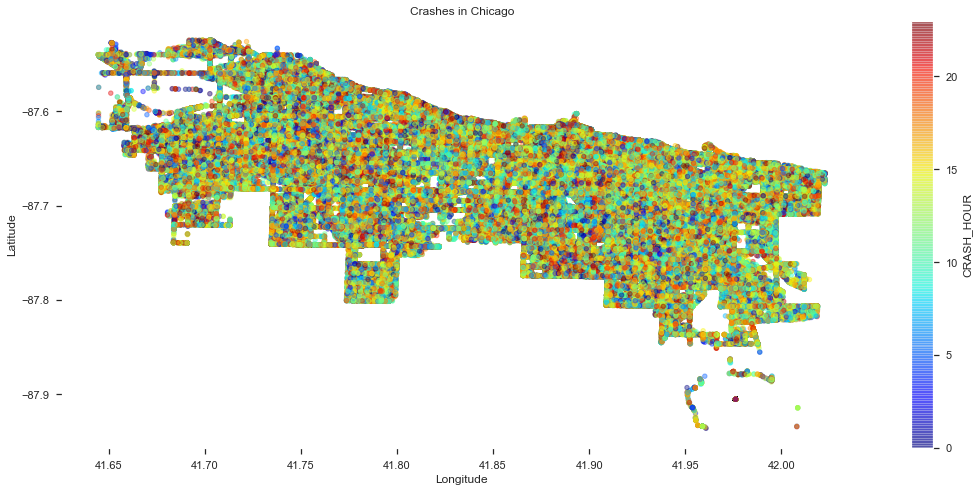

In [222]:
# Plot heatmap of all crahses usint latitude and longitude

fig,ax = plt.subplots()
plt.style.use('seaborn')
sns.set_context('notebook')
df[(df.LATITUDE != 0) & (df.LONGITUDE != 0)].plot(kind = 'scatter',x = 'LATITUDE', y = 'LONGITUDE', c = 'CRASH_HOUR', alpha = 0.4 , cmap=plt.get_cmap('jet'), colorbar = True, figsize = (15,7),ax=ax);
ax.grid(False)
ax.set_facecolor('White')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Crashes in Chicago');
plt.tight_layout()

In [5]:
df.columns

Index(['CRASH_RECORD_ID', 'RD_NO', 'CRASH_DATE_EST_I', 'CRASH_DATE',
       'POSTED_SPEED_LIMIT', 'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION',
       'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE',
       'TRAFFICWAY_TYPE', 'LANE_CNT', 'ALIGNMENT', 'ROADWAY_SURFACE_COND',
       'ROAD_DEFECT', 'REPORT_TYPE', 'CRASH_TYPE', 'INTERSECTION_RELATED_I',
       'NOT_RIGHT_OF_WAY_I', 'HIT_AND_RUN_I', 'DAMAGE', 'DATE_POLICE_NOTIFIED',
       'PRIM_CONTRIBUTORY_CAUSE', 'SEC_CONTRIBUTORY_CAUSE', 'STREET_NO',
       'STREET_DIRECTION', 'STREET_NAME', 'BEAT_OF_OCCURRENCE',
       'PHOTOS_TAKEN_I', 'STATEMENTS_TAKEN_I', 'DOORING_I', 'WORK_ZONE_I',
       'WORK_ZONE_TYPE', 'WORKERS_PRESENT_I', 'NUM_UNITS',
       'MOST_SEVERE_INJURY', 'INJURIES_TOTAL', 'INJURIES_FATAL',
       'INJURIES_INCAPACITATING', 'INJURIES_NON_INCAPACITATING',
       'INJURIES_REPORTED_NOT_EVIDENT', 'INJURIES_NO_INDICATION',
       'INJURIES_UNKNOWN', 'CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH',
       'LA

In [6]:
df['INJURIES_INCAPACITATING'].value_counts()

0.0    642587
1.0      9857
2.0      1000
3.0       242
4.0        80
5.0        20
6.0         5
7.0         1
Name: INJURIES_INCAPACITATING, dtype: int64

In [7]:
df['INJURIES_FATAL'].value_counts()

0.0    653088
1.0       653
2.0        43
3.0         7
4.0         1
Name: INJURIES_FATAL, dtype: int64

In [8]:
# Import People DataFrame

people_df = pd.read_csv('./Data/Traffic_Crashes_-_People.csv', dtype={'EMS_RUN_NO': 'str', 'PEDPEDAL_ACTION': 'str','PEDPEDAL_VISIBILITY': 'str', 'PEDPEDAL_LOCATION': 'str', 'CELL_PHONE_USE': 'str'})
people_df

,PERSON_ID,PERSON_TYPE,CRASH_RECORD_ID,RD_NO,VEHICLE_ID,CRASH_DATE,SEAT_NO,CITY,STATE,ZIPCODE,...,EMS_RUN_NO,DRIVER_ACTION,DRIVER_VISION,PHYSICAL_CONDITION,PEDPEDAL_ACTION,PEDPEDAL_VISIBILITY,PEDPEDAL_LOCATION,BAC_RESULT,BAC_RESULT VALUE,CELL_PHONE_USE
0,O749947,DRIVER,81dc0de2ed92aa62baccab641fa377be7feb1cc47e6554...,JC451435,834816.0,09/28/2019 03:30:00 AM,NaN,CHICAGO,IL,60651,...,NaN,UNKNOWN,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
1,O871921,DRIVER,af84fb5c8d996fcd3aefd36593c3a02e6e7509eeb27568...,JD208731,827212.0,04/13/2020 10:50:00 PM,NaN,CHICAGO,IL,60620,...,NaN,NONE,NOT OBSCURED,NORMAL,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
2,O10018,DRIVER,71162af7bf22799b776547132ebf134b5b438dcf3dac6b...,HY484534,9579.0,11/01/2015 05:00:00 AM,NaN,NaN,NaN,NaN,...,NaN,IMPROPER BACKING,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
3,O10038,DRIVER,c21c476e2ccc41af550b5d858d22aaac4ffc88745a1700...,HY484750,9598.0,11/01/2015 08:00:00 AM,NaN,NaN,NaN,NaN,...,NaN,UNKNOWN,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
4,O10039,DRIVER,eb390a4c8e114c69488f5fb8a097fe629f5a92fd528cf4...,HY484778,9600.0,11/01/2015 10:15:00 AM,NaN,NaN,NaN,NaN,...,NaN,UNKNOWN,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1437789,P317467,PASSENGER,d70adb92f8fcf973ac9221df82d0c4367886299d4ad857...,NaN,1358883.0,09/29/2022 10:10:00 AM,3.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1437790,P317470,PASSENGER,46efa7dc90474335637f2274702d3c8a84edc86e486fe5...,NaN,1358895.0,09/29/2022 08:49:00 AM,3.0,CHICAGO,IL,60628,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1437791,P317474,PASSENGER,46efa7dc90474335637f2274702d3c8a84edc86e486fe5...,NaN,1358895.0,09/29/2022 08:49:00 AM,4.0,CHICAGO,IL,60628,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1437792,P317477,PASSENGER,927ea20ffa0cf65bf1574a0562f6a009435b156e72d322...,NaN,1358899.0,09/29/2022 09:51:00 AM,3.0,CHICAGO,IL,60616,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
Age_Series = people_df.groupby(['CRASH_RECORD_ID'])[['AGE']].agg('median')
Age_Series

,AGE
CRASH_RECORD_ID,
000013b0123279411e0ec856dae95ab9f0851764350b7feaeb982c7707c6722066910e9391e60f45cec4b7a7a6643eeedb5de39e7245b03447a44c793680dc4b,51.0
00002c0771fb6f2c70ba775b7f6b501608cadea85c1dd1343228a53acd61a83b0e2b003ace79defc01b0f829fc47b9462027509b5e0ec1eaf3a5f2248121f379,35.0
000043c6564ec4d54bc4efd957d97ca97f38a965dd64b46b4ea46338c63fa875f71181d3e7056d22be66221a51ec6eca0b050ed5be812e331733616faae49fea,NaN
000070ed7a6357c3298f5edc6fb7d5ce925a10f46660f37f6c9b02e2a430d38ec739d2a5f45432979a01920c84f4700f6d4d63103a7878169bc1946367e8ee0a,47.5
0000b70a00c8809f76b5234f81753264d9160c314cc5e676cb229c2c15fa21188b243a53321fc6629b78da7bac5c20816c16fa0675a7284c0eed1d8751e1a371,NaN
...,...
ffffc0eaf9bc22a04bf318b62e0e1c5ec59a4f3c0c34936aebaf00612551ed488fd16a0367f8e15a77268560f0c6d0f4db6e441270063f35afacf0dfe70d7c09,NaN
ffffc784918a94c6d5ec9cdced500004faafc6a9e6e01b4ee4c6e5dd9f9f1a29faa55f329086abe588ecbd3ec14e13914f936aaadf417971bd9c924f5d2bdf03,NaN
ffffc802346fd6f48f99117898fbc558237a3052c327b875d4dabc837f7e59680b6fafaddf58d95ac0a0e8406f4b7f2024f0cc8517739756ac043a756ccb0b11,39.0


In [10]:
Person_Count_Series = people_df.groupby(['CRASH_RECORD_ID'])[['SEX']].agg('count')
Person_Count_Series.rename(columns = {'SEX' : 'PERSON_COUNT'}, inplace = True)

Person_Count_Series

,PERSON_COUNT
CRASH_RECORD_ID,
000013b0123279411e0ec856dae95ab9f0851764350b7feaeb982c7707c6722066910e9391e60f45cec4b7a7a6643eeedb5de39e7245b03447a44c793680dc4b,1
00002c0771fb6f2c70ba775b7f6b501608cadea85c1dd1343228a53acd61a83b0e2b003ace79defc01b0f829fc47b9462027509b5e0ec1eaf3a5f2248121f379,2
000043c6564ec4d54bc4efd957d97ca97f38a965dd64b46b4ea46338c63fa875f71181d3e7056d22be66221a51ec6eca0b050ed5be812e331733616faae49fea,1
000070ed7a6357c3298f5edc6fb7d5ce925a10f46660f37f6c9b02e2a430d38ec739d2a5f45432979a01920c84f4700f6d4d63103a7878169bc1946367e8ee0a,2
0000b70a00c8809f76b5234f81753264d9160c314cc5e676cb229c2c15fa21188b243a53321fc6629b78da7bac5c20816c16fa0675a7284c0eed1d8751e1a371,1
...,...
ffffc0eaf9bc22a04bf318b62e0e1c5ec59a4f3c0c34936aebaf00612551ed488fd16a0367f8e15a77268560f0c6d0f4db6e441270063f35afacf0dfe70d7c09,1
ffffc784918a94c6d5ec9cdced500004faafc6a9e6e01b4ee4c6e5dd9f9f1a29faa55f329086abe588ecbd3ec14e13914f936aaadf417971bd9c924f5d2bdf03,1
ffffc802346fd6f48f99117898fbc558237a3052c327b875d4dabc837f7e59680b6fafaddf58d95ac0a0e8406f4b7f2024f0cc8517739756ac043a756ccb0b11,3


In [11]:
Airbag_Series = people_df.groupby(['CRASH_RECORD_ID'])[['AIRBAG_DEPLOYED']].first()

Airbag_Series = pd.DataFrame(Airbag_Series['AIRBAG_DEPLOYED'].str.contains('DEPLOYED'))

Airbag_Series

,AIRBAG_DEPLOYED
CRASH_RECORD_ID,
000013b0123279411e0ec856dae95ab9f0851764350b7feaeb982c7707c6722066910e9391e60f45cec4b7a7a6643eeedb5de39e7245b03447a44c793680dc4b,False
00002c0771fb6f2c70ba775b7f6b501608cadea85c1dd1343228a53acd61a83b0e2b003ace79defc01b0f829fc47b9462027509b5e0ec1eaf3a5f2248121f379,False
000043c6564ec4d54bc4efd957d97ca97f38a965dd64b46b4ea46338c63fa875f71181d3e7056d22be66221a51ec6eca0b050ed5be812e331733616faae49fea,False
000070ed7a6357c3298f5edc6fb7d5ce925a10f46660f37f6c9b02e2a430d38ec739d2a5f45432979a01920c84f4700f6d4d63103a7878169bc1946367e8ee0a,False
0000b70a00c8809f76b5234f81753264d9160c314cc5e676cb229c2c15fa21188b243a53321fc6629b78da7bac5c20816c16fa0675a7284c0eed1d8751e1a371,False
...,...
ffffc0eaf9bc22a04bf318b62e0e1c5ec59a4f3c0c34936aebaf00612551ed488fd16a0367f8e15a77268560f0c6d0f4db6e441270063f35afacf0dfe70d7c09,False
ffffc784918a94c6d5ec9cdced500004faafc6a9e6e01b4ee4c6e5dd9f9f1a29faa55f329086abe588ecbd3ec14e13914f936aaadf417971bd9c924f5d2bdf03,False
ffffc802346fd6f48f99117898fbc558237a3052c327b875d4dabc837f7e59680b6fafaddf58d95ac0a0e8406f4b7f2024f0cc8517739756ac043a756ccb0b11,False


In [12]:
Safety_Series = people_df.groupby(['CRASH_RECORD_ID'])[['SAFETY_EQUIPMENT']].first()

equipment_list = ['NONE PRESENT','SAFETY BELT NOT USED','HELMET NOT USED','NOT DOT COMPLIANT MOTORCYCLE HELMET','SHOULD/LAP BELT USED IMPROPERLY','CHILD RESTRAINT NOT USED','CHILD RESTRAINT USED IMPROPERLY']

Safety_Series['BOOL'] = pd.DataFrame( (Safety_Series['SAFETY_EQUIPMENT'].isin(equipment_list)))

Safety_Series["BOOL"] =  ~Safety_Series["BOOL"]

Safety_Series.loc[Safety_Series['SAFETY_EQUIPMENT'] == 'USAGE UNKNOWN', ['BOOL']] = 'Unknown'

Safety_Series = Safety_Series[['BOOL']]

Safety_Series.rename(columns = {'BOOL' : 'SAFETY_EQUIPMENT'}, inplace = True)

Safety_Series

,SAFETY_EQUIPMENT
CRASH_RECORD_ID,
000013b0123279411e0ec856dae95ab9f0851764350b7feaeb982c7707c6722066910e9391e60f45cec4b7a7a6643eeedb5de39e7245b03447a44c793680dc4b,True
00002c0771fb6f2c70ba775b7f6b501608cadea85c1dd1343228a53acd61a83b0e2b003ace79defc01b0f829fc47b9462027509b5e0ec1eaf3a5f2248121f379,Unknown
000043c6564ec4d54bc4efd957d97ca97f38a965dd64b46b4ea46338c63fa875f71181d3e7056d22be66221a51ec6eca0b050ed5be812e331733616faae49fea,Unknown
000070ed7a6357c3298f5edc6fb7d5ce925a10f46660f37f6c9b02e2a430d38ec739d2a5f45432979a01920c84f4700f6d4d63103a7878169bc1946367e8ee0a,True
0000b70a00c8809f76b5234f81753264d9160c314cc5e676cb229c2c15fa21188b243a53321fc6629b78da7bac5c20816c16fa0675a7284c0eed1d8751e1a371,Unknown
...,...
ffffc0eaf9bc22a04bf318b62e0e1c5ec59a4f3c0c34936aebaf00612551ed488fd16a0367f8e15a77268560f0c6d0f4db6e441270063f35afacf0dfe70d7c09,Unknown
ffffc784918a94c6d5ec9cdced500004faafc6a9e6e01b4ee4c6e5dd9f9f1a29faa55f329086abe588ecbd3ec14e13914f936aaadf417971bd9c924f5d2bdf03,False
ffffc802346fd6f48f99117898fbc558237a3052c327b875d4dabc837f7e59680b6fafaddf58d95ac0a0e8406f4b7f2024f0cc8517739756ac043a756ccb0b11,Unknown


In [13]:
crashes_drop_columns = ['RD_NO', 'CRASH_DATE_EST_I', 'DATE_POLICE_NOTIFIED', 'STREET_NO', 'STREET_DIRECTION', 'STREET_NAME', 'BEAT_OF_OCCURRENCE','PHOTOS_TAKEN_I', 'STATEMENTS_TAKEN_I', 'DOORING_I', 'WORK_ZONE_I', 'WORK_ZONE_TYPE', 'WORKERS_PRESENT_I']
df = df.drop(crashes_drop_columns, axis = 1)

df

,CRASH_RECORD_ID,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,LANE_CNT,...,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,LOCATION
0,79c7a2ce89f446262efd86df3d72d18b04ba487024b7c4...,03/25/2019 02:43:00 PM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,TURNING,ONE-WAY,4.0,...,0.0,1.0,2.0,0.0,14,2,3,41.884547,-87.641201,POINT (-87.64120093714 41.884547224337)
1,792b539deaaad65ee5b4a9691d927a34d298eb33d42af0...,09/05/2018 08:40:00 AM,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,ANGLE,NOT DIVIDED,2.0,...,0.0,0.0,2.0,0.0,8,4,9,41.968562,-87.740659,POINT (-87.740659314632 41.968562453871)
2,0115ade9a755e835255508463f7e9c4a9a0b47e9304238...,07/15/2022 12:45:00 AM,30,UNKNOWN,UNKNOWN,CLEAR,"DARKNESS, LIGHTED ROAD",ANGLE,NOT DIVIDED,NaN,...,0.0,0.0,2.0,0.0,0,6,7,41.886336,-87.716203,POINT (-87.716203130599 41.886336409761)
3,05b1982cdba5d8a00e7e76ad1ecdab0e598429f78481d2...,08/29/2022 11:30:00 AM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,FOUR WAY,NaN,...,0.0,0.0,3.0,0.0,11,2,8,41.749348,-87.721097,POINT (-87.721096727406 41.749348170421)
4,017040c61958d2fa977c956b2bd2d6759ef7754496dc96...,07/15/2022 06:50:00 PM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,NOT DIVIDED,NaN,...,0.0,0.0,2.0,0.0,18,6,7,41.925111,-87.667997,POINT (-87.667997321599 41.925110815832)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
655177,bf86786457a08ebccd20d6480ed2c5c295e04a51004578...,06/09/2020 08:00:00 PM,30,STOP SIGN/FLASHER,FUNCTIONING PROPERLY,RAIN,"DARKNESS, LIGHTED ROAD",ANGLE,FOUR WAY,NaN,...,0.0,0.0,2.0,0.0,20,3,6,41.777927,-87.638835,POINT (-87.638834655301 41.777926777918)
655178,b91bf1a5a13ca3d15213b2313a1a0df8105ad129f4b42a...,07/27/2022 03:05:00 PM,35,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,TURNING,NOT DIVIDED,NaN,...,0.0,6.0,0.0,0.0,15,4,7,41.847677,-87.678317,POINT (-87.678316682197 41.847677200391)
655179,cea9e897c768f47b97c73685c1a2b3fdcdcd8809a0517a...,07/05/2019 03:50:00 AM,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,REAR TO FRONT,PARKING LOT,NaN,...,0.0,0.0,2.0,0.0,3,6,7,41.787127,-87.645488,POINT (-87.645487943954 41.787127441561)
655180,f0ae5a7b71091d7beb2d12a2a1b68dbc0320cc892158a6...,06/08/2020 12:57:00 PM,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,TURNING,NOT DIVIDED,NaN,...,0.0,0.0,2.0,0.0,12,2,6,41.727744,-87.581784,POINT (-87.581784088558 41.72774434911)


In [14]:
df_merge_1 = df.merge(Age_Series, how = 'inner', on = 'CRASH_RECORD_ID')
df_merge_1

,CRASH_RECORD_ID,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,LANE_CNT,...,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,LOCATION,AGE
0,79c7a2ce89f446262efd86df3d72d18b04ba487024b7c4...,03/25/2019 02:43:00 PM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,TURNING,ONE-WAY,4.0,...,1.0,2.0,0.0,14,2,3,41.884547,-87.641201,POINT (-87.64120093714 41.884547224337),27.0
1,792b539deaaad65ee5b4a9691d927a34d298eb33d42af0...,09/05/2018 08:40:00 AM,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,ANGLE,NOT DIVIDED,2.0,...,0.0,2.0,0.0,8,4,9,41.968562,-87.740659,POINT (-87.740659314632 41.968562453871),35.5
2,0115ade9a755e835255508463f7e9c4a9a0b47e9304238...,07/15/2022 12:45:00 AM,30,UNKNOWN,UNKNOWN,CLEAR,"DARKNESS, LIGHTED ROAD",ANGLE,NOT DIVIDED,NaN,...,0.0,2.0,0.0,0,6,7,41.886336,-87.716203,POINT (-87.716203130599 41.886336409761),62.0
3,05b1982cdba5d8a00e7e76ad1ecdab0e598429f78481d2...,08/29/2022 11:30:00 AM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,FOUR WAY,NaN,...,0.0,3.0,0.0,11,2,8,41.749348,-87.721097,POINT (-87.721096727406 41.749348170421),40.0
4,017040c61958d2fa977c956b2bd2d6759ef7754496dc96...,07/15/2022 06:50:00 PM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,NOT DIVIDED,NaN,...,0.0,2.0,0.0,18,6,7,41.925111,-87.667997,POINT (-87.667997321599 41.925110815832),53.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
653782,bf86786457a08ebccd20d6480ed2c5c295e04a51004578...,06/09/2020 08:00:00 PM,30,STOP SIGN/FLASHER,FUNCTIONING PROPERLY,RAIN,"DARKNESS, LIGHTED ROAD",ANGLE,FOUR WAY,NaN,...,0.0,2.0,0.0,20,3,6,41.777927,-87.638835,POINT (-87.638834655301 41.777926777918),34.0
653783,b91bf1a5a13ca3d15213b2313a1a0df8105ad129f4b42a...,07/27/2022 03:05:00 PM,35,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,TURNING,NOT DIVIDED,NaN,...,6.0,0.0,0.0,15,4,7,41.847677,-87.678317,POINT (-87.678316682197 41.847677200391),26.0
653784,cea9e897c768f47b97c73685c1a2b3fdcdcd8809a0517a...,07/05/2019 03:50:00 AM,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,REAR TO FRONT,PARKING LOT,NaN,...,0.0,2.0,0.0,3,6,7,41.787127,-87.645488,POINT (-87.645487943954 41.787127441561),26.5
653785,f0ae5a7b71091d7beb2d12a2a1b68dbc0320cc892158a6...,06/08/2020 12:57:00 PM,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,TURNING,NOT DIVIDED,NaN,...,0.0,2.0,0.0,12,2,6,41.727744,-87.581784,POINT (-87.581784088558 41.72774434911),31.5


In [15]:
df_merge_2 = df_merge_1.merge(Person_Count_Series, how = 'inner', on = 'CRASH_RECORD_ID')
df_merge_2

,CRASH_RECORD_ID,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,LANE_CNT,...,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,LOCATION,AGE,PERSON_COUNT
0,79c7a2ce89f446262efd86df3d72d18b04ba487024b7c4...,03/25/2019 02:43:00 PM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,TURNING,ONE-WAY,4.0,...,2.0,0.0,14,2,3,41.884547,-87.641201,POINT (-87.64120093714 41.884547224337),27.0,3
1,792b539deaaad65ee5b4a9691d927a34d298eb33d42af0...,09/05/2018 08:40:00 AM,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,ANGLE,NOT DIVIDED,2.0,...,2.0,0.0,8,4,9,41.968562,-87.740659,POINT (-87.740659314632 41.968562453871),35.5,2
2,0115ade9a755e835255508463f7e9c4a9a0b47e9304238...,07/15/2022 12:45:00 AM,30,UNKNOWN,UNKNOWN,CLEAR,"DARKNESS, LIGHTED ROAD",ANGLE,NOT DIVIDED,NaN,...,2.0,0.0,0,6,7,41.886336,-87.716203,POINT (-87.716203130599 41.886336409761),62.0,2
3,05b1982cdba5d8a00e7e76ad1ecdab0e598429f78481d2...,08/29/2022 11:30:00 AM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,FOUR WAY,NaN,...,3.0,0.0,11,2,8,41.749348,-87.721097,POINT (-87.721096727406 41.749348170421),40.0,3
4,017040c61958d2fa977c956b2bd2d6759ef7754496dc96...,07/15/2022 06:50:00 PM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,NOT DIVIDED,NaN,...,2.0,0.0,18,6,7,41.925111,-87.667997,POINT (-87.667997321599 41.925110815832),53.5,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
653782,bf86786457a08ebccd20d6480ed2c5c295e04a51004578...,06/09/2020 08:00:00 PM,30,STOP SIGN/FLASHER,FUNCTIONING PROPERLY,RAIN,"DARKNESS, LIGHTED ROAD",ANGLE,FOUR WAY,NaN,...,2.0,0.0,20,3,6,41.777927,-87.638835,POINT (-87.638834655301 41.777926777918),34.0,4
653783,b91bf1a5a13ca3d15213b2313a1a0df8105ad129f4b42a...,07/27/2022 03:05:00 PM,35,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,TURNING,NOT DIVIDED,NaN,...,0.0,0.0,15,4,7,41.847677,-87.678317,POINT (-87.678316682197 41.847677200391),26.0,8
653784,cea9e897c768f47b97c73685c1a2b3fdcdcd8809a0517a...,07/05/2019 03:50:00 AM,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,REAR TO FRONT,PARKING LOT,NaN,...,2.0,0.0,3,6,7,41.787127,-87.645488,POINT (-87.645487943954 41.787127441561),26.5,4
653785,f0ae5a7b71091d7beb2d12a2a1b68dbc0320cc892158a6...,06/08/2020 12:57:00 PM,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,TURNING,NOT DIVIDED,NaN,...,2.0,0.0,12,2,6,41.727744,-87.581784,POINT (-87.581784088558 41.72774434911),31.5,4


In [16]:
df_merge_3 = df_merge_2.merge(Airbag_Series, how = 'inner', on = 'CRASH_RECORD_ID')
df_merge_3

,CRASH_RECORD_ID,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,LANE_CNT,...,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,LOCATION,AGE,PERSON_COUNT,AIRBAG_DEPLOYED
0,79c7a2ce89f446262efd86df3d72d18b04ba487024b7c4...,03/25/2019 02:43:00 PM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,TURNING,ONE-WAY,4.0,...,0.0,14,2,3,41.884547,-87.641201,POINT (-87.64120093714 41.884547224337),27.0,3,False
1,792b539deaaad65ee5b4a9691d927a34d298eb33d42af0...,09/05/2018 08:40:00 AM,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,ANGLE,NOT DIVIDED,2.0,...,0.0,8,4,9,41.968562,-87.740659,POINT (-87.740659314632 41.968562453871),35.5,2,False
2,0115ade9a755e835255508463f7e9c4a9a0b47e9304238...,07/15/2022 12:45:00 AM,30,UNKNOWN,UNKNOWN,CLEAR,"DARKNESS, LIGHTED ROAD",ANGLE,NOT DIVIDED,NaN,...,0.0,0,6,7,41.886336,-87.716203,POINT (-87.716203130599 41.886336409761),62.0,2,False
3,05b1982cdba5d8a00e7e76ad1ecdab0e598429f78481d2...,08/29/2022 11:30:00 AM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,FOUR WAY,NaN,...,0.0,11,2,8,41.749348,-87.721097,POINT (-87.721096727406 41.749348170421),40.0,3,False
4,017040c61958d2fa977c956b2bd2d6759ef7754496dc96...,07/15/2022 06:50:00 PM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,NOT DIVIDED,NaN,...,0.0,18,6,7,41.925111,-87.667997,POINT (-87.667997321599 41.925110815832),53.5,2,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
653782,bf86786457a08ebccd20d6480ed2c5c295e04a51004578...,06/09/2020 08:00:00 PM,30,STOP SIGN/FLASHER,FUNCTIONING PROPERLY,RAIN,"DARKNESS, LIGHTED ROAD",ANGLE,FOUR WAY,NaN,...,0.0,20,3,6,41.777927,-87.638835,POINT (-87.638834655301 41.777926777918),34.0,4,False
653783,b91bf1a5a13ca3d15213b2313a1a0df8105ad129f4b42a...,07/27/2022 03:05:00 PM,35,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,TURNING,NOT DIVIDED,NaN,...,0.0,15,4,7,41.847677,-87.678317,POINT (-87.678316682197 41.847677200391),26.0,8,False
653784,cea9e897c768f47b97c73685c1a2b3fdcdcd8809a0517a...,07/05/2019 03:50:00 AM,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,REAR TO FRONT,PARKING LOT,NaN,...,0.0,3,6,7,41.787127,-87.645488,POINT (-87.645487943954 41.787127441561),26.5,4,False
653785,f0ae5a7b71091d7beb2d12a2a1b68dbc0320cc892158a6...,06/08/2020 12:57:00 PM,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,TURNING,NOT DIVIDED,NaN,...,0.0,12,2,6,41.727744,-87.581784,POINT (-87.581784088558 41.72774434911),31.5,4,False


In [17]:
df_merge_4 = df_merge_3.merge(Safety_Series, how = 'inner', on = 'CRASH_RECORD_ID')
df_merge_4

,CRASH_RECORD_ID,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,LANE_CNT,...,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,LOCATION,AGE,PERSON_COUNT,AIRBAG_DEPLOYED,SAFETY_EQUIPMENT
0,79c7a2ce89f446262efd86df3d72d18b04ba487024b7c4...,03/25/2019 02:43:00 PM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,TURNING,ONE-WAY,4.0,...,14,2,3,41.884547,-87.641201,POINT (-87.64120093714 41.884547224337),27.0,3,False,True
1,792b539deaaad65ee5b4a9691d927a34d298eb33d42af0...,09/05/2018 08:40:00 AM,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,ANGLE,NOT DIVIDED,2.0,...,8,4,9,41.968562,-87.740659,POINT (-87.740659314632 41.968562453871),35.5,2,False,True
2,0115ade9a755e835255508463f7e9c4a9a0b47e9304238...,07/15/2022 12:45:00 AM,30,UNKNOWN,UNKNOWN,CLEAR,"DARKNESS, LIGHTED ROAD",ANGLE,NOT DIVIDED,NaN,...,0,6,7,41.886336,-87.716203,POINT (-87.716203130599 41.886336409761),62.0,2,False,Unknown
3,05b1982cdba5d8a00e7e76ad1ecdab0e598429f78481d2...,08/29/2022 11:30:00 AM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,FOUR WAY,NaN,...,11,2,8,41.749348,-87.721097,POINT (-87.721096727406 41.749348170421),40.0,3,False,Unknown
4,017040c61958d2fa977c956b2bd2d6759ef7754496dc96...,07/15/2022 06:50:00 PM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,NOT DIVIDED,NaN,...,18,6,7,41.925111,-87.667997,POINT (-87.667997321599 41.925110815832),53.5,2,False,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
653782,bf86786457a08ebccd20d6480ed2c5c295e04a51004578...,06/09/2020 08:00:00 PM,30,STOP SIGN/FLASHER,FUNCTIONING PROPERLY,RAIN,"DARKNESS, LIGHTED ROAD",ANGLE,FOUR WAY,NaN,...,20,3,6,41.777927,-87.638835,POINT (-87.638834655301 41.777926777918),34.0,4,False,True
653783,b91bf1a5a13ca3d15213b2313a1a0df8105ad129f4b42a...,07/27/2022 03:05:00 PM,35,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,TURNING,NOT DIVIDED,NaN,...,15,4,7,41.847677,-87.678317,POINT (-87.678316682197 41.847677200391),26.0,8,False,Unknown
653784,cea9e897c768f47b97c73685c1a2b3fdcdcd8809a0517a...,07/05/2019 03:50:00 AM,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,REAR TO FRONT,PARKING LOT,NaN,...,3,6,7,41.787127,-87.645488,POINT (-87.645487943954 41.787127441561),26.5,4,False,Unknown
653785,f0ae5a7b71091d7beb2d12a2a1b68dbc0320cc892158a6...,06/08/2020 12:57:00 PM,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,TURNING,NOT DIVIDED,NaN,...,12,2,6,41.727744,-87.581784,POINT (-87.581784088558 41.72774434911),31.5,4,False,True


In [18]:
vehicles_df = pd.read_csv('./Data/Traffic_Crashes_-_Vehicles.csv')

vehicles_df.sort_values(by = 'CRASH_RECORD_ID')

/Users/lindstromkyle/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (19,21,40,41,42,44,48,49,50,53,55,58,59,61) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,CRASH_UNIT_ID,CRASH_RECORD_ID,RD_NO,CRASH_DATE,UNIT_NO,UNIT_TYPE,NUM_PASSENGERS,VEHICLE_ID,CMRC_VEH_I,MAKE,...,TRAILER1_LENGTH,TRAILER2_LENGTH,TOTAL_VEHICLE_LENGTH,AXLE_CNT,VEHICLE_CONFIG,CARGO_BODY_TYPE,LOAD_TYPE,HAZMAT_OUT_OF_SERVICE_I,MCS_OUT_OF_SERVICE_I,HAZMAT_CLASS
135905,995163,000013b0123279411e0ec856dae95ab9f0851764350b7f...,JD433095,11/16/2020 01:50:00 PM,1,DRIVER,NaN,943049.0,NaN,HYUNDAI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
135906,995164,000013b0123279411e0ec856dae95ab9f0851764350b7f...,JD433095,11/16/2020 01:50:00 PM,2,PARKED,NaN,943051.0,NaN,CHEVROLET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
787526,40893,00002c0771fb6f2c70ba775b7f6b501608cadea85c1dd1...,HZ228060,04/16/2016 05:49:00 AM,1,DRIVER,NaN,39524.0,NaN,LINCOLN-CONTINENTAL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
787537,40894,00002c0771fb6f2c70ba775b7f6b501608cadea85c1dd1...,HZ228060,04/16/2016 05:49:00 AM,2,DRIVER,NaN,39526.0,NaN,HYUNDAI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1191787,807770,000043c6564ec4d54bc4efd957d97ca97f38a965dd64b4...,JC556033,12/22/2019 02:11:00 AM,1,DRIVER,NaN,767006.0,NaN,LINCOLN-CONTINENTAL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134278,926885,ffffc802346fd6f48f99117898fbc558237a3052c327b8...,JD312526,07/28/2020 07:30:00 AM,2,DRIVER,1.0,878760.0,NaN,TOYOTA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
815704,436457,ffffe467b0d2d95c897e8c2721941f87dede1661a3b60c...,JB356563,07/19/2018 03:40:00 PM,1,DRIVER,NaN,418822.0,NaN,CHEVROLET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
815705,436458,ffffe467b0d2d95c897e8c2721941f87dede1661a3b60c...,JB356563,07/19/2018 03:40:00 PM,2,DRIVER,NaN,418825.0,NaN,"TOYOTA MOTOR COMPANY, LTD.",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27639,846340,ffffe577251dc1cc67f2f823b595e5028427a210e2a40e...,JD158296,02/20/2020 08:00:00 AM,2,DRIVER,NaN,803161.0,NaN,VOLVO,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
pivot = pd.pivot_table(vehicles_df, columns = 'UNIT_NO', index='CRASH_RECORD_ID', values = 'VEHICLE_TYPE', aggfunc = 'first')
pivot.iloc[:,1:3]

UNIT_NO,1,2
CRASH_RECORD_ID,,
000013b0123279411e0ec856dae95ab9f0851764350b7feaeb982c7707c6722066910e9391e60f45cec4b7a7a6643eeedb5de39e7245b03447a44c793680dc4b,PASSENGER,SPORT UTILITY VEHICLE (SUV)
00002c0771fb6f2c70ba775b7f6b501608cadea85c1dd1343228a53acd61a83b0e2b003ace79defc01b0f829fc47b9462027509b5e0ec1eaf3a5f2248121f379,SPORT UTILITY VEHICLE (SUV),PASSENGER
000043c6564ec4d54bc4efd957d97ca97f38a965dd64b46b4ea46338c63fa875f71181d3e7056d22be66221a51ec6eca0b050ed5be812e331733616faae49fea,PASSENGER,NaN
000070ed7a6357c3298f5edc6fb7d5ce925a10f46660f37f6c9b02e2a430d38ec739d2a5f45432979a01920c84f4700f6d4d63103a7878169bc1946367e8ee0a,PASSENGER,PASSENGER
0000b70a00c8809f76b5234f81753264d9160c314cc5e676cb229c2c15fa21188b243a53321fc6629b78da7bac5c20816c16fa0675a7284c0eed1d8751e1a371,VAN/MINI-VAN,SPORT UTILITY VEHICLE (SUV)
...,...,...
ffffc0eaf9bc22a04bf318b62e0e1c5ec59a4f3c0c34936aebaf00612551ed488fd16a0367f8e15a77268560f0c6d0f4db6e441270063f35afacf0dfe70d7c09,PASSENGER,TRUCK - SINGLE UNIT
ffffc784918a94c6d5ec9cdced500004faafc6a9e6e01b4ee4c6e5dd9f9f1a29faa55f329086abe588ecbd3ec14e13914f936aaadf417971bd9c924f5d2bdf03,TRUCK - SINGLE UNIT,VAN/MINI-VAN
ffffc802346fd6f48f99117898fbc558237a3052c327b875d4dabc837f7e59680b6fafaddf58d95ac0a0e8406f4b7f2024f0cc8517739756ac043a756ccb0b11,PASSENGER,PASSENGER


In [20]:
pivot2 = pd.pivot_table(vehicles_df, columns = 'UNIT_NO', index='CRASH_RECORD_ID', values = 'FIRST_CONTACT_POINT', aggfunc = 'first')
pivot2.iloc[:,1:3]

UNIT_NO,1,2
CRASH_RECORD_ID,,
000013b0123279411e0ec856dae95ab9f0851764350b7feaeb982c7707c6722066910e9391e60f45cec4b7a7a6643eeedb5de39e7245b03447a44c793680dc4b,FRONT,SIDE-LEFT
00002c0771fb6f2c70ba775b7f6b501608cadea85c1dd1343228a53acd61a83b0e2b003ace79defc01b0f829fc47b9462027509b5e0ec1eaf3a5f2248121f379,FRONT-RIGHT,SIDE-LEFT
000043c6564ec4d54bc4efd957d97ca97f38a965dd64b46b4ea46338c63fa875f71181d3e7056d22be66221a51ec6eca0b050ed5be812e331733616faae49fea,TOTAL (ALL AREAS),NaN
000070ed7a6357c3298f5edc6fb7d5ce925a10f46660f37f6c9b02e2a430d38ec739d2a5f45432979a01920c84f4700f6d4d63103a7878169bc1946367e8ee0a,FRONT-LEFT,SIDE-RIGHT
0000b70a00c8809f76b5234f81753264d9160c314cc5e676cb229c2c15fa21188b243a53321fc6629b78da7bac5c20816c16fa0675a7284c0eed1d8751e1a371,REAR-LEFT,OTHER
...,...,...
ffffc0eaf9bc22a04bf318b62e0e1c5ec59a4f3c0c34936aebaf00612551ed488fd16a0367f8e15a77268560f0c6d0f4db6e441270063f35afacf0dfe70d7c09,SIDE-RIGHT,REAR
ffffc784918a94c6d5ec9cdced500004faafc6a9e6e01b4ee4c6e5dd9f9f1a29faa55f329086abe588ecbd3ec14e13914f936aaadf417971bd9c924f5d2bdf03,NONE,REAR
ffffc802346fd6f48f99117898fbc558237a3052c327b875d4dabc837f7e59680b6fafaddf58d95ac0a0e8406f4b7f2024f0cc8517739756ac043a756ccb0b11,OTHER,OTHER


In [223]:
df_merge_5 = df_merge_4.merge(pivot.iloc[:,1:3], how = 'inner', on = 'CRASH_RECORD_ID')
df_merge_5

,CRASH_RECORD_ID,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,LANE_CNT,...,CRASH_MONTH,LATITUDE,LONGITUDE,LOCATION,AGE,PERSON_COUNT,AIRBAG_DEPLOYED,SAFETY_EQUIPMENT,1,2
0,79c7a2ce89f446262efd86df3d72d18b04ba487024b7c4...,03/25/2019 02:43:00 PM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,TURNING,ONE-WAY,4.0,...,3,41.884547,-87.641201,POINT (-87.64120093714 41.884547224337),27.0,3,False,True,PASSENGER,PASSENGER
1,792b539deaaad65ee5b4a9691d927a34d298eb33d42af0...,09/05/2018 08:40:00 AM,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,ANGLE,NOT DIVIDED,2.0,...,9,41.968562,-87.740659,POINT (-87.740659314632 41.968562453871),35.5,2,False,True,SPORT UTILITY VEHICLE (SUV),PASSENGER
2,0115ade9a755e835255508463f7e9c4a9a0b47e9304238...,07/15/2022 12:45:00 AM,30,UNKNOWN,UNKNOWN,CLEAR,"DARKNESS, LIGHTED ROAD",ANGLE,NOT DIVIDED,NaN,...,7,41.886336,-87.716203,POINT (-87.716203130599 41.886336409761),62.0,2,False,Unknown,UNKNOWN/NA,UNKNOWN/NA
3,05b1982cdba5d8a00e7e76ad1ecdab0e598429f78481d2...,08/29/2022 11:30:00 AM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,FOUR WAY,NaN,...,8,41.749348,-87.721097,POINT (-87.721096727406 41.749348170421),40.0,3,False,Unknown,UNKNOWN/NA,TRACTOR W/ SEMI-TRAILER
4,017040c61958d2fa977c956b2bd2d6759ef7754496dc96...,07/15/2022 06:50:00 PM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,NOT DIVIDED,NaN,...,7,41.925111,-87.667997,POINT (-87.667997321599 41.925110815832),53.5,2,False,Unknown,PASSENGER,PASSENGER
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
653696,bf86786457a08ebccd20d6480ed2c5c295e04a51004578...,06/09/2020 08:00:00 PM,30,STOP SIGN/FLASHER,FUNCTIONING PROPERLY,RAIN,"DARKNESS, LIGHTED ROAD",ANGLE,FOUR WAY,NaN,...,6,41.777927,-87.638835,POINT (-87.638834655301 41.777926777918),34.0,4,False,True,PASSENGER,PASSENGER
653697,b91bf1a5a13ca3d15213b2313a1a0df8105ad129f4b42a...,07/27/2022 03:05:00 PM,35,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,TURNING,NOT DIVIDED,NaN,...,7,41.847677,-87.678317,POINT (-87.678316682197 41.847677200391),26.0,8,False,Unknown,UNKNOWN/NA,PASSENGER
653698,cea9e897c768f47b97c73685c1a2b3fdcdcd8809a0517a...,07/05/2019 03:50:00 AM,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,REAR TO FRONT,PARKING LOT,NaN,...,7,41.787127,-87.645488,POINT (-87.645487943954 41.787127441561),26.5,4,False,Unknown,PASSENGER,PASSENGER
653699,f0ae5a7b71091d7beb2d12a2a1b68dbc0320cc892158a6...,06/08/2020 12:57:00 PM,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,TURNING,NOT DIVIDED,NaN,...,6,41.727744,-87.581784,POINT (-87.581784088558 41.72774434911),31.5,4,False,True,PASSENGER,PASSENGER


In [22]:
"""df_merge_6 = df_merge_5.merge(pivot2.iloc[:,1:3], how = 'inner', on = 'CRASH_RECORD_ID')
df_merge_6"""

"df_merge_6 = df_merge_5.merge(pivot2.iloc[:,1:3], how = 'inner', on = 'CRASH_RECORD_ID')\ndf_merge_6"

In [23]:
df_merge_5.dtypes

CRASH_RECORD_ID                   object
CRASH_DATE                        object
POSTED_SPEED_LIMIT                 int64
TRAFFIC_CONTROL_DEVICE            object
DEVICE_CONDITION                  object
WEATHER_CONDITION                 object
LIGHTING_CONDITION                object
FIRST_CRASH_TYPE                  object
TRAFFICWAY_TYPE                   object
LANE_CNT                         float64
ALIGNMENT                         object
ROADWAY_SURFACE_COND              object
ROAD_DEFECT                       object
REPORT_TYPE                       object
CRASH_TYPE                        object
INTERSECTION_RELATED_I            object
NOT_RIGHT_OF_WAY_I                object
HIT_AND_RUN_I                     object
DAMAGE                            object
PRIM_CONTRIBUTORY_CAUSE           object
SEC_CONTRIBUTORY_CAUSE            object
NUM_UNITS                          int64
MOST_SEVERE_INJURY                object
INJURIES_TOTAL                   float64
INJURIES_FATAL  

In [297]:
more_drop_cols = ['TRAFFIC_CONTROL_DEVICE','DEVICE_CONDITION','LANE_CNT','REPORT_TYPE','INTERSECTION_RELATED_I','HIT_AND_RUN_I','CRASH_MONTH','LATITUDE','LONGITUDE','LOCATION','INJURIES_TOTAL','INJURIES_FATAL','INJURIES_INCAPACITATING','INJURIES_NON_INCAPACITATING','INJURIES_REPORTED_NOT_EVIDENT','INJURIES_NO_INDICATION','INJURIES_UNKNOWN','CRASH_MONTH','TRAFFICWAY_TYPE','CRASH_TYPE','PRIM_CONTRIBUTORY_CAUSE','SEC_CONTRIBUTORY_CAUSE','NOT_RIGHT_OF_WAY_I']
df_full = df_merge_5.drop(more_drop_cols, axis = 1)
df_full['MOST_SEVERE_INJURY'].value_counts()

NO INDICATION OF INJURY     565687
NONINCAPACITATING INJURY     49555
REPORTED, NOT EVIDENT        26652
INCAPACITATING INJURY        11092
FATAL                          704
Name: MOST_SEVERE_INJURY, dtype: int64

In [298]:
df_full['INJURIES_ONLY_TARGET'] = df_full['MOST_SEVERE_INJURY']
df_full['INJURIES_ONLY_TARGET'] = df_full['INJURIES_ONLY_TARGET'].apply(lambda x: 2 if x == 'NO INDICATION OF INJURY' or x == 'REPORTED, NOT EVIDENT' else x)
df_full['INJURIES_ONLY_TARGET'] = df_full['INJURIES_ONLY_TARGET'].apply(lambda x: 0 if x == 'NONINCAPACITATING INJURY' else x)
df_full['INJURIES_ONLY_TARGET'] = df_full['INJURIES_ONLY_TARGET'].apply(lambda x: 1 if x == 'INCAPACITATING INJURY' or x == 'FATAL' else x)
df_full['INJURIES_ONLY_TARGET'] = df_full['INJURIES_ONLY_TARGET'].fillna(2)

df_full['FATAL/INCAPACITATING_INJURY'] = True

df_full['TARGET_2'] = True

injury_list = ['NO INDICATION OF INJURY','NONINCAPACITATING INJURY','REPORTED, NOT EVIDENT']
injury_list_2 = ['NO INDICATION OF INJURY','REPORTED, NOT EVIDENT']

df_full.loc[(df_full['MOST_SEVERE_INJURY'].isin(injury_list)) | (df_full['MOST_SEVERE_INJURY'].isna()), ['FATAL/INCAPACITATING_INJURY']] = False

df_full.loc[(df_full['MOST_SEVERE_INJURY'].isin(injury_list_2)) | (df_full['MOST_SEVERE_INJURY'].isna()), ['TARGET_2']] = False

df_full = df_full.drop('MOST_SEVERE_INJURY', axis = 1)


df_full

,CRASH_RECORD_ID,CRASH_DATE,POSTED_SPEED_LIMIT,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,ALIGNMENT,ROADWAY_SURFACE_COND,ROAD_DEFECT,DAMAGE,...,CRASH_DAY_OF_WEEK,AGE,PERSON_COUNT,AIRBAG_DEPLOYED,SAFETY_EQUIPMENT,1,2,INJURIES_ONLY_TARGET,FATAL/INCAPACITATING_INJURY,TARGET_2
0,79c7a2ce89f446262efd86df3d72d18b04ba487024b7c4...,03/25/2019 02:43:00 PM,30,CLEAR,DAYLIGHT,TURNING,STRAIGHT AND LEVEL,DRY,NO DEFECTS,"OVER $1,500",...,2,27.0,3,False,True,PASSENGER,PASSENGER,2.0,False,False
1,792b539deaaad65ee5b4a9691d927a34d298eb33d42af0...,09/05/2018 08:40:00 AM,30,CLEAR,DAYLIGHT,ANGLE,STRAIGHT AND LEVEL,DRY,NO DEFECTS,"OVER $1,500",...,4,35.5,2,False,True,SPORT UTILITY VEHICLE (SUV),PASSENGER,2.0,False,False
2,0115ade9a755e835255508463f7e9c4a9a0b47e9304238...,07/15/2022 12:45:00 AM,30,CLEAR,"DARKNESS, LIGHTED ROAD",ANGLE,STRAIGHT AND LEVEL,DRY,UNKNOWN,"OVER $1,500",...,6,62.0,2,False,Unknown,UNKNOWN/NA,UNKNOWN/NA,2.0,False,False
3,05b1982cdba5d8a00e7e76ad1ecdab0e598429f78481d2...,08/29/2022 11:30:00 AM,30,CLEAR,DAYLIGHT,REAR END,STRAIGHT AND LEVEL,DRY,NO DEFECTS,"$501 - $1,500",...,2,40.0,3,False,Unknown,UNKNOWN/NA,TRACTOR W/ SEMI-TRAILER,2.0,False,False
4,017040c61958d2fa977c956b2bd2d6759ef7754496dc96...,07/15/2022 06:50:00 PM,30,CLEAR,DAYLIGHT,REAR END,STRAIGHT AND LEVEL,DRY,NO DEFECTS,"OVER $1,500",...,6,53.5,2,False,Unknown,PASSENGER,PASSENGER,2.0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
653696,bf86786457a08ebccd20d6480ed2c5c295e04a51004578...,06/09/2020 08:00:00 PM,30,RAIN,"DARKNESS, LIGHTED ROAD",ANGLE,STRAIGHT AND LEVEL,WET,NO DEFECTS,"OVER $1,500",...,3,34.0,4,False,True,PASSENGER,PASSENGER,2.0,False,False
653697,b91bf1a5a13ca3d15213b2313a1a0df8105ad129f4b42a...,07/27/2022 03:05:00 PM,35,CLEAR,DAYLIGHT,TURNING,STRAIGHT AND LEVEL,DRY,NO DEFECTS,"OVER $1,500",...,4,26.0,8,False,Unknown,UNKNOWN/NA,PASSENGER,2.0,False,False
653698,cea9e897c768f47b97c73685c1a2b3fdcdcd8809a0517a...,07/05/2019 03:50:00 AM,30,CLEAR,DAYLIGHT,REAR TO FRONT,STRAIGHT AND LEVEL,DRY,NO DEFECTS,"OVER $1,500",...,6,26.5,4,False,Unknown,PASSENGER,PASSENGER,2.0,False,False
653699,f0ae5a7b71091d7beb2d12a2a1b68dbc0320cc892158a6...,06/08/2020 12:57:00 PM,30,CLEAR,DAYLIGHT,TURNING,STRAIGHT AND LEVEL,DRY,NO DEFECTS,"OVER $1,500",...,2,31.5,4,False,True,PASSENGER,PASSENGER,2.0,False,False


In [300]:
#df_full.columns
df_full['ALIGNMENT'] = df_full['ALIGNMENT'].apply(lambda x: 'STRAIGHT AND LEVEL' if x == 'STRAIGHT AND LEVEL' else 'NOT STRAIGHT AND LEVEL')
df_full['ALIGNMENT'].value_counts()

STRAIGHT AND LEVEL        637203
NOT STRAIGHT AND LEVEL     16498
Name: ALIGNMENT, dtype: int64

In [301]:
def label_weather(row):
    if row['WEATHER_CONDITION'] in ['RAIN', 'SNOW','FREEZING RAIN/DRIZZLE','SLEET/HAIL','BLOWING SNOW']:
        return 'RAIN/SNOW'
    elif row['WEATHER_CONDITION'] in ['CLOUDY/OVERCAST', 'FOG/SMOKE/HAZE', 'SEVERE CROSS WIND GATE', 'BLOWING SAND, SOIL, DIRT','OTHER']:
        return 'OTHER'
    elif row['WEATHER_CONDITION'] in ['CLEAR']:
        return 'CLEAR'
    elif row['WEATHER_CONDITION'] in ['UNKNOWN']:
        return 'UNKNOWN'


df_full['WEATHER_CONDITION'] = df_full.apply(lambda row: label_weather(row), axis=1)

In [302]:
df_full['WEATHER_CONDITION'].value_counts()

CLEAR        518453
RAIN/SNOW     81785
UNKNOWN       31228
OTHER         22235
Name: WEATHER_CONDITION, dtype: int64

In [303]:
df_full['LIGHTING_CONDITION'].value_counts()

DAYLIGHT                  424626
DARKNESS, LIGHTED ROAD    141992
DARKNESS                   31056
UNKNOWN                    25990
DUSK                       19094
DAWN                       10943
Name: LIGHTING_CONDITION, dtype: int64

In [304]:
df_full['LIGHTING_CONDITION'] = df_full['LIGHTING_CONDITION'].apply(lambda x: 'TWILIGHT' if x == 'DUSK' or x == 'DAWN' else x)
df_full['LIGHTING_CONDITION'].value_counts()

DAYLIGHT                  424626
DARKNESS, LIGHTED ROAD    141992
DARKNESS                   31056
TWILIGHT                   30037
UNKNOWN                    25990
Name: LIGHTING_CONDITION, dtype: int64

In [305]:
df_full['FIRST_CRASH_TYPE'].value_counts()

PARKED MOTOR VEHICLE            152354
REAR END                        150222
SIDESWIPE SAME DIRECTION         99608
TURNING                          92385
ANGLE                            70294
FIXED OBJECT                     30459
PEDESTRIAN                       14819
PEDALCYCLIST                      9785
SIDESWIPE OPPOSITE DIRECTION      9364
OTHER OBJECT                      6296
HEAD ON                           5599
REAR TO FRONT                     5306
REAR TO SIDE                      3146
OTHER NONCOLLISION                2037
REAR TO REAR                      1151
ANIMAL                             449
OVERTURNED                         391
TRAIN                               36
Name: FIRST_CRASH_TYPE, dtype: int64

In [306]:
def label_crashtype(row):
    if row['FIRST_CRASH_TYPE'] in ['PARKED MOTOR VEHICLE','FIXED OBJECT','REAR TO REAR','REAR TO SIDE','ANIMAL','OTHER OBJECT']:
        return 'PARKED/OBJECT/SLOW'
    elif row['FIRST_CRASH_TYPE'] in ['REAR END', 'SIDESWIPE SAME DIRECTION', 'REAR TO FRONT']:
        return 'SAME DIRECTION'
    elif row['FIRST_CRASH_TYPE'] in ['HEAD ON','OVERTURNED','TRAIN']:
        return 'HEAD ON/OVERTURNED/TRAIN'
    elif row['FIRST_CRASH_TYPE'] in ['TURNING','ANGLE','SIDESWIPE OPPOSITE DIRECTION']:
        return 'ANGEL/SIDE'
    elif row['FIRST_CRASH_TYPE'] in ['PEDESTRIAN','PEDALCYCLIST','SIDESWIPE OPPOSITE DIRECTION']:
        return 'PEDESTRIAN/CYCLIST'


df_full['FIRST_CRASH_TYPE'] = df_full.apply(lambda row: label_crashtype(row), axis=1)
df_full['FIRST_CRASH_TYPE'].value_counts()

SAME DIRECTION              255136
PARKED/OBJECT/SLOW          193855
ANGEL/SIDE                  172043
PEDESTRIAN/CYCLIST           24604
HEAD ON/OVERTURNED/TRAIN      6026
Name: FIRST_CRASH_TYPE, dtype: int64

In [307]:
df_full['ROADWAY_SURFACE_COND'].value_counts()

DRY                488974
WET                 85934
UNKNOWN             48129
SNOW OR SLUSH       24093
ICE                  4713
OTHER                1601
SAND, MUD, DIRT       257
Name: ROADWAY_SURFACE_COND, dtype: int64

In [308]:
df_full['ROADWAY_SURFACE_COND'] = df_full['ROADWAY_SURFACE_COND'].apply(lambda x: 'OTHER' if x == 'SNOW OR SLUSH' or x == 'ICE' or x =='SAND, MUD, DIRT' else x)
df_full['ROADWAY_SURFACE_COND'].value_counts()

DRY        488974
WET         85934
UNKNOWN     48129
OTHER       30664
Name: ROADWAY_SURFACE_COND, dtype: int64

In [309]:
df_full['ROAD_DEFECT'] = df_full['ROAD_DEFECT'].apply(lambda x: 'DEFECT' if x == 'RUT, HOLES' or x == 'OTHER' or x =='WORN SURFACE' or x == 'SHOULDER DEFECT' or x == 'DEBRIS ON ROADWAY' else x)
df_full['ROAD_DEFECT'].value_counts()

NO DEFECTS    536386
UNKNOWN       103730
DEFECT         13585
Name: ROAD_DEFECT, dtype: int64

In [310]:
df_full['SAFETY_EQUIPMENT'] = df_full['SAFETY_EQUIPMENT'].apply(lambda x: 'Yes' if x == True else x)
df_full['SAFETY_EQUIPMENT'] = df_full['SAFETY_EQUIPMENT'].apply(lambda x: 'No' if x == False else x)
df_full['SAFETY_EQUIPMENT'].value_counts() 

Unknown    389350
Yes        245897
No          18454
Name: SAFETY_EQUIPMENT, dtype: int64

In [311]:
df_full['AIRBAG_DEPLOYED'] = df_full['AIRBAG_DEPLOYED'].apply(lambda x: 'Yes' if x == True else x)
df_full['AIRBAG_DEPLOYED'] = df_full['AIRBAG_DEPLOYED'].apply(lambda x: 'No' if x == False else x)
df_full['AIRBAG_DEPLOYED'].value_counts() 

No     613848
Yes     39351
Name: AIRBAG_DEPLOYED, dtype: int64

In [312]:
df_full['FATAL/INCAPACITATING_INJURY'] = df_full['FATAL/INCAPACITATING_INJURY'].apply(lambda x: 1 if x == True else x)
df_full['FATAL/INCAPACITATING_INJURY'] = df_full['FATAL/INCAPACITATING_INJURY'].apply(lambda x: 0 if x == False else x)
df_full['FATAL/INCAPACITATING_INJURY'].value_counts()

0    641905
1     11796
Name: FATAL/INCAPACITATING_INJURY, dtype: int64

In [313]:
df_full['TARGET_2'] = df_full['TARGET_2'].apply(lambda x: 1 if x == True else x)
df_full['TARGET_2'] = df_full['TARGET_2'].apply(lambda x: 0 if x == False else x)
df_full['TARGET_2'].value_counts()

0    592350
1     61351
Name: TARGET_2, dtype: int64

In [314]:
df_full['DAMAGE'].value_counts()

OVER $1,500      393260
$501 - $1,500    182463
$500 OR LESS      77978
Name: DAMAGE, dtype: int64

In [315]:
df_full['DAMAGE'] = df_full['DAMAGE'].apply(lambda x: 'UNDER $1500' if x == '$501 - $1,500' or x == '$500 OR LESS' else x)
df_full

,CRASH_RECORD_ID,CRASH_DATE,POSTED_SPEED_LIMIT,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,ALIGNMENT,ROADWAY_SURFACE_COND,ROAD_DEFECT,DAMAGE,...,CRASH_DAY_OF_WEEK,AGE,PERSON_COUNT,AIRBAG_DEPLOYED,SAFETY_EQUIPMENT,1,2,INJURIES_ONLY_TARGET,FATAL/INCAPACITATING_INJURY,TARGET_2
0,79c7a2ce89f446262efd86df3d72d18b04ba487024b7c4...,03/25/2019 02:43:00 PM,30,CLEAR,DAYLIGHT,ANGEL/SIDE,STRAIGHT AND LEVEL,DRY,NO DEFECTS,"OVER $1,500",...,2,27.0,3,No,Yes,PASSENGER,PASSENGER,2.0,0,0
1,792b539deaaad65ee5b4a9691d927a34d298eb33d42af0...,09/05/2018 08:40:00 AM,30,CLEAR,DAYLIGHT,ANGEL/SIDE,STRAIGHT AND LEVEL,DRY,NO DEFECTS,"OVER $1,500",...,4,35.5,2,No,Yes,SPORT UTILITY VEHICLE (SUV),PASSENGER,2.0,0,0
2,0115ade9a755e835255508463f7e9c4a9a0b47e9304238...,07/15/2022 12:45:00 AM,30,CLEAR,"DARKNESS, LIGHTED ROAD",ANGEL/SIDE,STRAIGHT AND LEVEL,DRY,UNKNOWN,"OVER $1,500",...,6,62.0,2,No,Unknown,UNKNOWN/NA,UNKNOWN/NA,2.0,0,0
3,05b1982cdba5d8a00e7e76ad1ecdab0e598429f78481d2...,08/29/2022 11:30:00 AM,30,CLEAR,DAYLIGHT,SAME DIRECTION,STRAIGHT AND LEVEL,DRY,NO DEFECTS,UNDER $1500,...,2,40.0,3,No,Unknown,UNKNOWN/NA,TRACTOR W/ SEMI-TRAILER,2.0,0,0
4,017040c61958d2fa977c956b2bd2d6759ef7754496dc96...,07/15/2022 06:50:00 PM,30,CLEAR,DAYLIGHT,SAME DIRECTION,STRAIGHT AND LEVEL,DRY,NO DEFECTS,"OVER $1,500",...,6,53.5,2,No,Unknown,PASSENGER,PASSENGER,2.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
653696,bf86786457a08ebccd20d6480ed2c5c295e04a51004578...,06/09/2020 08:00:00 PM,30,RAIN/SNOW,"DARKNESS, LIGHTED ROAD",ANGEL/SIDE,STRAIGHT AND LEVEL,WET,NO DEFECTS,"OVER $1,500",...,3,34.0,4,No,Yes,PASSENGER,PASSENGER,2.0,0,0
653697,b91bf1a5a13ca3d15213b2313a1a0df8105ad129f4b42a...,07/27/2022 03:05:00 PM,35,CLEAR,DAYLIGHT,ANGEL/SIDE,STRAIGHT AND LEVEL,DRY,NO DEFECTS,"OVER $1,500",...,4,26.0,8,No,Unknown,UNKNOWN/NA,PASSENGER,2.0,0,0
653698,cea9e897c768f47b97c73685c1a2b3fdcdcd8809a0517a...,07/05/2019 03:50:00 AM,30,CLEAR,DAYLIGHT,SAME DIRECTION,STRAIGHT AND LEVEL,DRY,NO DEFECTS,"OVER $1,500",...,6,26.5,4,No,Unknown,PASSENGER,PASSENGER,2.0,0,0
653699,f0ae5a7b71091d7beb2d12a2a1b68dbc0320cc892158a6...,06/08/2020 12:57:00 PM,30,CLEAR,DAYLIGHT,ANGEL/SIDE,STRAIGHT AND LEVEL,DRY,NO DEFECTS,"OVER $1,500",...,2,31.5,4,No,Yes,PASSENGER,PASSENGER,2.0,0,0


In [316]:
df_model = df_full.drop(['CRASH_RECORD_ID','CRASH_DATE',1,2], axis = 1)
df_model

,POSTED_SPEED_LIMIT,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,ALIGNMENT,ROADWAY_SURFACE_COND,ROAD_DEFECT,DAMAGE,NUM_UNITS,CRASH_HOUR,CRASH_DAY_OF_WEEK,AGE,PERSON_COUNT,AIRBAG_DEPLOYED,SAFETY_EQUIPMENT,INJURIES_ONLY_TARGET,FATAL/INCAPACITATING_INJURY,TARGET_2
0,30,CLEAR,DAYLIGHT,ANGEL/SIDE,STRAIGHT AND LEVEL,DRY,NO DEFECTS,"OVER $1,500",2,14,2,27.0,3,No,Yes,2.0,0,0
1,30,CLEAR,DAYLIGHT,ANGEL/SIDE,STRAIGHT AND LEVEL,DRY,NO DEFECTS,"OVER $1,500",2,8,4,35.5,2,No,Yes,2.0,0,0
2,30,CLEAR,"DARKNESS, LIGHTED ROAD",ANGEL/SIDE,STRAIGHT AND LEVEL,DRY,UNKNOWN,"OVER $1,500",2,0,6,62.0,2,No,Unknown,2.0,0,0
3,30,CLEAR,DAYLIGHT,SAME DIRECTION,STRAIGHT AND LEVEL,DRY,NO DEFECTS,UNDER $1500,2,11,2,40.0,3,No,Unknown,2.0,0,0
4,30,CLEAR,DAYLIGHT,SAME DIRECTION,STRAIGHT AND LEVEL,DRY,NO DEFECTS,"OVER $1,500",2,18,6,53.5,2,No,Unknown,2.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
653696,30,RAIN/SNOW,"DARKNESS, LIGHTED ROAD",ANGEL/SIDE,STRAIGHT AND LEVEL,WET,NO DEFECTS,"OVER $1,500",2,20,3,34.0,4,No,Yes,2.0,0,0
653697,35,CLEAR,DAYLIGHT,ANGEL/SIDE,STRAIGHT AND LEVEL,DRY,NO DEFECTS,"OVER $1,500",2,15,4,26.0,8,No,Unknown,2.0,0,0
653698,30,CLEAR,DAYLIGHT,SAME DIRECTION,STRAIGHT AND LEVEL,DRY,NO DEFECTS,"OVER $1,500",2,3,6,26.5,4,No,Unknown,2.0,0,0
653699,30,CLEAR,DAYLIGHT,ANGEL/SIDE,STRAIGHT AND LEVEL,DRY,NO DEFECTS,"OVER $1,500",2,12,2,31.5,4,No,Yes,2.0,0,0


In [317]:
df_model.isna().sum()

POSTED_SPEED_LIMIT                  0
WEATHER_CONDITION                   0
LIGHTING_CONDITION                  0
FIRST_CRASH_TYPE                 2037
ALIGNMENT                           0
ROADWAY_SURFACE_COND                0
ROAD_DEFECT                         0
DAMAGE                              0
NUM_UNITS                           0
CRASH_HOUR                          0
CRASH_DAY_OF_WEEK                   0
AGE                            117251
PERSON_COUNT                        0
AIRBAG_DEPLOYED                   502
SAFETY_EQUIPMENT                    0
INJURIES_ONLY_TARGET                0
FATAL/INCAPACITATING_INJURY         0
TARGET_2                            0
dtype: int64

In [318]:
df_model = df_model.dropna(subset = ['FIRST_CRASH_TYPE','AIRBAG_DEPLOYED'], axis = 0)

In [319]:
df_model.isna().sum()

POSTED_SPEED_LIMIT                  0
WEATHER_CONDITION                   0
LIGHTING_CONDITION                  0
FIRST_CRASH_TYPE                    0
ALIGNMENT                           0
ROADWAY_SURFACE_COND                0
ROAD_DEFECT                         0
DAMAGE                              0
NUM_UNITS                           0
CRASH_HOUR                          0
CRASH_DAY_OF_WEEK                   0
AGE                            116961
PERSON_COUNT                        0
AIRBAG_DEPLOYED                     0
SAFETY_EQUIPMENT                    0
INJURIES_ONLY_TARGET                0
FATAL/INCAPACITATING_INJURY         0
TARGET_2                            0
dtype: int64

In [320]:
X = df_model.drop(['FATAL/INCAPACITATING_INJURY','TARGET_2','INJURIES_ONLY_TARGET'], axis = 1)
y = df_model['FATAL/INCAPACITATING_INJURY']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 14)
X

,POSTED_SPEED_LIMIT,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,ALIGNMENT,ROADWAY_SURFACE_COND,ROAD_DEFECT,DAMAGE,NUM_UNITS,CRASH_HOUR,CRASH_DAY_OF_WEEK,AGE,PERSON_COUNT,AIRBAG_DEPLOYED,SAFETY_EQUIPMENT
0,30,CLEAR,DAYLIGHT,ANGEL/SIDE,STRAIGHT AND LEVEL,DRY,NO DEFECTS,"OVER $1,500",2,14,2,27.0,3,No,Yes
1,30,CLEAR,DAYLIGHT,ANGEL/SIDE,STRAIGHT AND LEVEL,DRY,NO DEFECTS,"OVER $1,500",2,8,4,35.5,2,No,Yes
2,30,CLEAR,"DARKNESS, LIGHTED ROAD",ANGEL/SIDE,STRAIGHT AND LEVEL,DRY,UNKNOWN,"OVER $1,500",2,0,6,62.0,2,No,Unknown
3,30,CLEAR,DAYLIGHT,SAME DIRECTION,STRAIGHT AND LEVEL,DRY,NO DEFECTS,UNDER $1500,2,11,2,40.0,3,No,Unknown
4,30,CLEAR,DAYLIGHT,SAME DIRECTION,STRAIGHT AND LEVEL,DRY,NO DEFECTS,"OVER $1,500",2,18,6,53.5,2,No,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
653696,30,RAIN/SNOW,"DARKNESS, LIGHTED ROAD",ANGEL/SIDE,STRAIGHT AND LEVEL,WET,NO DEFECTS,"OVER $1,500",2,20,3,34.0,4,No,Yes
653697,35,CLEAR,DAYLIGHT,ANGEL/SIDE,STRAIGHT AND LEVEL,DRY,NO DEFECTS,"OVER $1,500",2,15,4,26.0,8,No,Unknown
653698,30,CLEAR,DAYLIGHT,SAME DIRECTION,STRAIGHT AND LEVEL,DRY,NO DEFECTS,"OVER $1,500",2,3,6,26.5,4,No,Unknown
653699,30,CLEAR,DAYLIGHT,ANGEL/SIDE,STRAIGHT AND LEVEL,DRY,NO DEFECTS,"OVER $1,500",2,12,2,31.5,4,No,Yes


# DUMMY CLASSIFIER

Dummy Classifier TEST Recall Score: 0.0
Dummy Classifier TEST Precision Score: 0.0


/Users/lindstromkyle/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


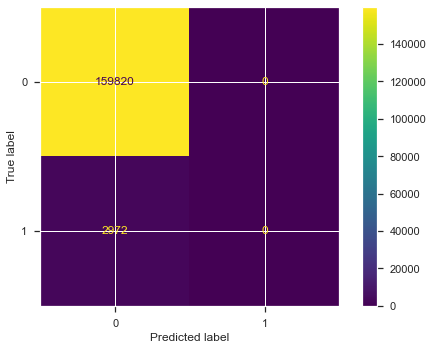

In [321]:
dummy = DummyClassifier(strategy = 'most_frequent')

dummy.fit(X_train,y_train)

plot_confusion_matrix(dummy, X_test, y_test)

print('Dummy Classifier TEST Recall Score:', recall_score(y_test,dummy.predict(X_test)))
print('Dummy Classifier TEST Precision Score:', precision_score(y_test,dummy.predict(X_test)))

# DECISION TREE

In [269]:
num = ['AGE']
cat = ['WEATHER_CONDITION','LIGHTING_CONDITION','FIRST_CRASH_TYPE','ALIGNMENT','ROADWAY_SURFACE_COND','ROAD_DEFECT','AIRBAG_DEPLOYED','SAFETY_EQUIPMENT','DAMAGE']

num_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy = 'median'))])

cat_transformer = Pipeline(steps=[('onehot', OneHotEncoder())])

preprocessor = ColumnTransformer(transformers=[('num', num_transformer, num),
                                               ('cat', cat_transformer, cat)])

pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('classifier', DecisionTreeClassifier( class_weight = 'balanced'))])

pipe.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['AGE']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  ['WEATHER_CONDITION',
                                                   'LIGHTING_CONDITION',
                                                   'FIRST_CRASH_TYPE',
                                                   'ALIGNMENT',
                                                   'ROADWAY_SURFACE_COND',
                                                   'ROAD_DEFECT',
                          

Decision Tree TRAIN Recall Score: 0.9011127681541815
Decision Tree TRAIN Precision Score: 0.10914876469443904


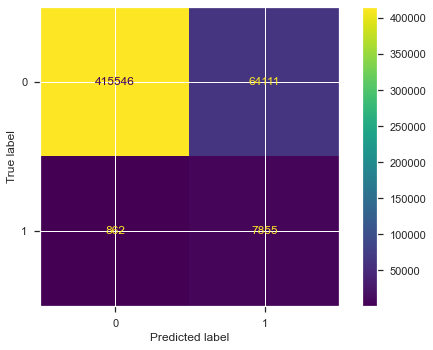

In [270]:
plot_confusion_matrix(pipe, X_train, y_train)

train_predict = pipe.predict(X_train)

print('Decision Tree TRAIN Recall Score:', recall_score(y_train, train_predict))
print('Decision Tree TRAIN Precision Score:', precision_score(y_train, train_predict))

Decision Tree TEST Recall Score: 0.3943472409152086
Decision Tree TEST Precision Score: 0.04974955429153578


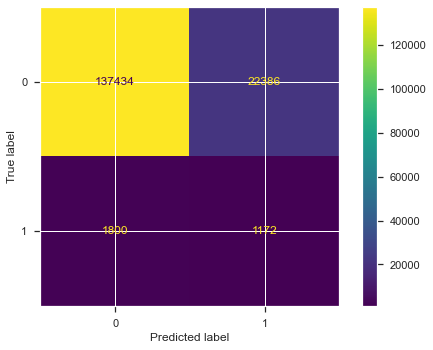

In [271]:
plot_confusion_matrix(pipe, X_test, y_test)

test_predict = pipe.predict(X_test)

print('Decision Tree TEST Recall Score:', recall_score(y_test, test_predict))
print('Decision Tree TEST Precision Score:', precision_score(y_test, test_predict))

# RANDOM FOREST

In [48]:
pipe2 = Pipeline(steps=[('preprocessor', preprocessor),
                       ('classifier', RandomForestClassifier( max_depth = 10, class_weight = 'balanced_subsample'))])

pipe2.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['AGE']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  ['WEATHER_CONDITION',
                                                   'LIGHTING_CONDITION',
                                                   'FIRST_CRASH_TYPE',
                                                   'ALIGNMENT',
                                                   'ROADWAY_SURFACE_COND',
                                                   'ROAD_DEFECT',
                          

Random Forest TRAIN Recall Score: 0.6450613743260296
Random Forest TRAIN Precision Score: 0.09489975021940188


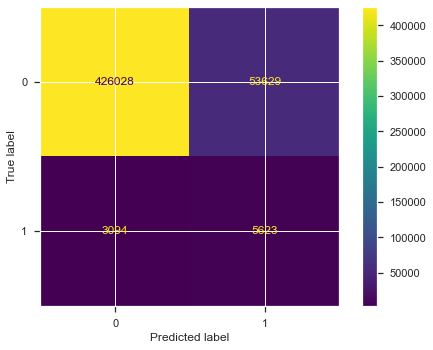

In [49]:
plot_confusion_matrix(pipe2, X_train, y_train)

train_predict_2 = pipe2.predict(X_train)

print('Random Forest TRAIN Recall Score:', recall_score(y_train, train_predict_2))
print('Random Forest TRAIN Precision Score:', precision_score(y_train, train_predict_2))

Random Forest TEST Recall Score: 0.6258411843876177
Random Forest TEST Precision Score: 0.09535038704054954


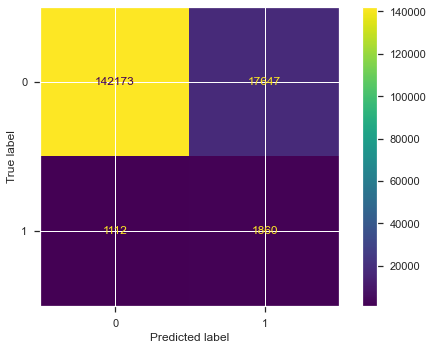

In [50]:
plot_confusion_matrix(pipe2, X_test, y_test)

test_predict_2 = pipe2.predict(X_test)

print('Random Forest TEST Recall Score:', recall_score(y_test, test_predict_2))
print('Random Forest TEST Precision Score:', precision_score(y_test, test_predict_2))

# ADABOOST

In [163]:
pipe3 = Pipeline(steps=[('preprocessor', preprocessor),
                       ('classifier', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight = 'balanced', max_depth = 3)) )])

pipe3.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['AGE']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  ['WEATHER_CONDITION',
                                                   'LIGHTING_CONDITION',
                                                   'FIRST_CRASH_TYPE',
                                                   'ALIGNMENT',
                                                   'ROADWAY_SURFACE_COND',
                                                   'ROAD_DEFECT',
                          

ADA Boost TRAIN Recall Score: 0.6781002638522428
ADA Boost TRAIN Precision Score: 0.07941903584672436


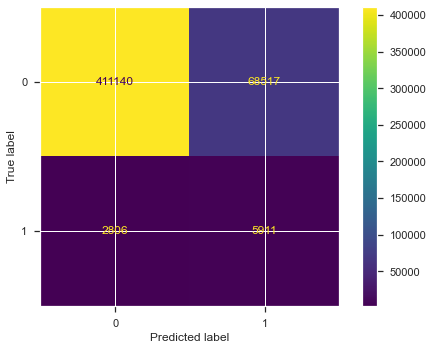

In [164]:
plot_confusion_matrix(pipe3, X_train, y_train)

train_predict_3 = pipe3.predict(X_train)

print('ADA Boost TRAIN Recall Score:', recall_score(y_train, train_predict_3))
print('ADA Boost TRAIN Precision Score:', precision_score(y_train, train_predict_3))

ADA Boost TEST Recall Score: 0.6621803499327052
ADA Boost TEST Precision Score: 0.07977300364815565


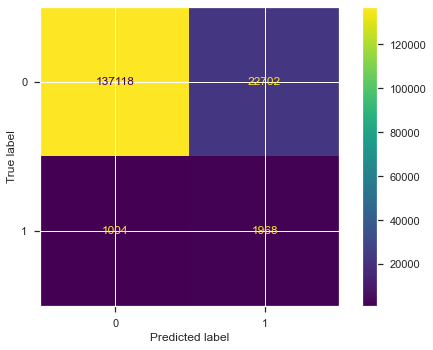

In [165]:
plot_confusion_matrix(pipe3, X_test, y_test)

test_predict_3 = pipe3.predict(X_test)

print('ADA Boost TEST Recall Score:', recall_score(y_test, test_predict_3))
print('ADA Boost TEST Precision Score:', precision_score(y_test, test_predict_3))

# Gradient Boost

In [60]:
pipe4 = Pipeline(steps=[('preprocessor', preprocessor),
                       ('classifier', GradientBoostingClassifier() )])

pipe4.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['AGE']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  ['WEATHER_CONDITION',
                                                   'LIGHTING_CONDITION',
                                                   'FIRST_CRASH_TYPE',
                                                   'ALIGNMENT',
                                                   'ROADWAY_SURFACE_COND',
                                                   'ROAD_DEFECT',
                          

Random Forest TRAIN Recall Score: 0.001147183664104623
Random Forest TRAIN Precision Score: 0.9090909090909091


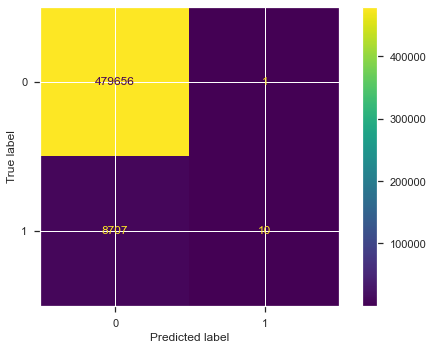

In [61]:
plot_confusion_matrix(pipe4, X_train, y_train)

train_predict_4 = pipe4.predict(X_train)

print('Gradient Boost TRAIN Recall Score:', recall_score(y_train, train_predict_4))
print('Gradient Boost TRAIN Precision Score:', precision_score(y_train, train_predict_4))

Gradient Boost TEST Recall Score: 0.00033647375504710633
Gradient Boost TEST Precision Score: 0.25


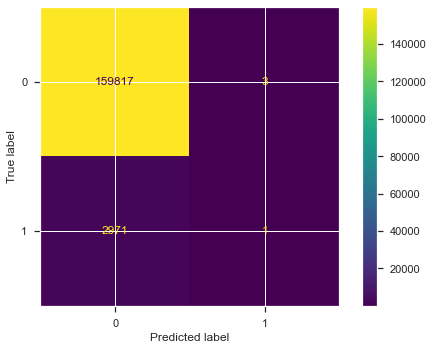

In [62]:
plot_confusion_matrix(pipe4, X_test, y_test)

test_predict_4 = pipe4.predict(X_test)

print('Gradient Boost TEST Recall Score:', recall_score(y_test, test_predict_4))
print('Gradient Boost TEST Precision Score:', precision_score(y_test, test_predict_4))

# XGBoost

In [63]:


pipe5 = Pipeline(steps=[('preprocessor', preprocessor),
                       ('classifier', XGBClassifier(scale_pos_weight=54) )])  

pipe5.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['AGE']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  ['WEATHER_CONDITION',
                                                   'LIGHTING_CONDITION',
                                                   'FIRST_CRASH_TYPE',
                                                   'ALIGNMENT',
                                                   'ROADWAY_SURFACE_COND',
                                                   'ROAD_DEFECT',
                          

XGBoost TRAIN Recall Score: 0.7231845818515544
XGBoost TRAIN Precision Score: 0.08767732962447844


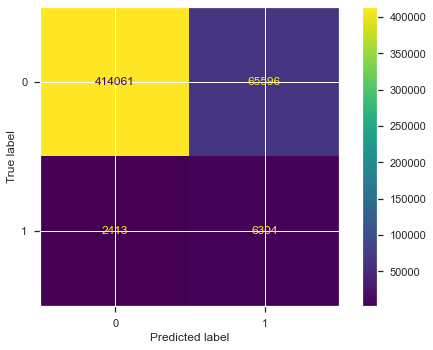

In [64]:
plot_confusion_matrix(pipe5, X_train, y_train)

train_predict_5 = pipe5.predict(X_train)

print('XGBoost TRAIN Recall Score:', recall_score(y_train, train_predict_5))
print('XGBoost TRAIN Precision Score:', precision_score(y_train, train_predict_5))

XGBoost TEST Recall Score: 0.6372812920592194
XGBoost TEST Precision Score: 0.07930991164524098


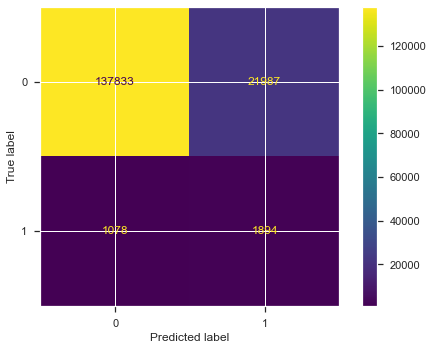

In [65]:
plot_confusion_matrix(pipe5, X_test, y_test)

test_predict_5 = pipe5.predict(X_test)

print('XGBoost TEST Recall Score:', recall_score(y_test, test_predict_5))
print('XGBoost TEST Precision Score:', precision_score(y_test, test_predict_5))

# Grid Search

In [68]:
param_grid = {'classifier__scale_pos_weight' : [1, 54, 100]}
gs = GridSearchCV(pipe5, param_grid = param_grid, scoring = 'recall', cv = 3)

gs.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median'))]),
                                                                         ['AGE']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder())]),
                                                                         ['WEATHER_CONDITION',
                                                                          'LIGHTING_CONDITION',
                                                     

In [69]:
gs.cv_results_

{'mean_fit_time': array([15.35931865, 15.91117477, 17.3346645 ]),
 'std_fit_time': array([0.23177898, 0.10660417, 0.35501204]),
 'mean_score_time': array([0.67466243, 0.70002826, 0.69254692]),
 'std_score_time': array([0.00837806, 0.04096392, 0.01709148]),
 'param_classiffier__scale_pos_weight': masked_array(data=[1, 54, 100],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'classiffier__scale_pos_weight': 1},
  {'classiffier__scale_pos_weight': 54},
  {'classiffier__scale_pos_weight': 100}],
 'split0_test_score': array([0.00378527, 0.61975224, 0.74569855]),
 'split1_test_score': array([0.0020654 , 0.6444062 , 0.75972461]),
 'split2_test_score': array([0.00240881, 0.62044047, 0.74707502]),
 'mean_test_score': array([0.00275316, 0.62819963, 0.75083273]),
 'std_test_score': array([0.00074316, 0.01146321, 0.00631257]),
 'rank_test_score': array([3, 2, 1], dtype=int32)}

In [70]:
gs.best_params_

{'classiffier__scale_pos_weight': 100}

In [458]:
param_grid2 = {'classifier__max_leaves' : [1, 10, 20]}
gs2 = GridSearchCV(pipe5, param_grid = param_grid2, scoring = 'recall', cv = 3)

gs2.fit(X_train, y_train)

ValueError: Invalid parameter classifier for estimator Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['AGE']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  ['WEATHER_CONDITION',
                                                   'LIGHTING_CONDITION',
                                                   'FIRST_CRASH_TYPE',
                                                   'ALIGNMENT',
                                                   'ROADWAY_SURFACE_COND',
                                                   'ROAD_DEFECT',
                                                   'AIRBAG_DEPLOYED',
                                                   'SAFETY_EQUIPMENT'])])),
                ('c...
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=54,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verbosity=None))]). Check the list of available parameters with `estimator.get_params().keys()`.

In [81]:
gs2.cv_results_

{'mean_fit_time': array([15.07250166, 16.07975769, 16.00649309]),
 'std_fit_time': array([0.66662342, 0.16279804, 0.1169965 ]),
 'mean_score_time': array([0.64377999, 0.63343668, 0.72088973]),
 'std_score_time': array([0.01229744, 0.00337433, 0.00496095]),
 'param_classiffier__scale_pos_weight': masked_array(data=[1, 54, 100],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'classiffier__scale_pos_weight': 1},
  {'classiffier__scale_pos_weight': 54},
  {'classiffier__scale_pos_weight': 100}],
 'split0_test_score': array([0.82188763, 0.80646127, 0.80017579]),
 'split1_test_score': array([0.83214649, 0.81618954, 0.80808334]),
 'split2_test_score': array([0.82507358, 0.80680376, 0.79517192]),
 'mean_test_score': array([0.82636923, 0.80981819, 0.80114369]),
 'std_test_score': array([0.0042872 , 0.00450739, 0.00531531]),
 'rank_test_score': array([1, 2, 3], dtype=int32)}

In [82]:
gs2.best_params_

{'classiffier__scale_pos_weight': 1}

In [187]:
from sklearn.utils.class_weight import compute_sample_weight
sample_weights = compute_sample_weight(class_weight='balanced', y = y_train)


pipe6 = Pipeline(steps=[('preprocessor', preprocessor),
                       ('classifier', XGBClassifier(max_depth = 4, max_leaves = 10, eta = 0.1, subsample = 0.66) )])

pipe6.fit(X_train,y_train, classifier__sample_weight=sample_weights)



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['AGE']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  ['WEATHER_CONDITION',
                                                   'LIGHTING_CONDITION',
                                                   'FIRST_CRASH_TYPE',
                                                   'ALIGNMENT',
                                                   'ROADWAY_SURFACE_COND',
                                                   'ROAD_DEFECT',
                          

XGBoost TRAIN Recall Score: 0.6707582884019732
XGBoost TRAIN Precision Score: 0.08188043523925556


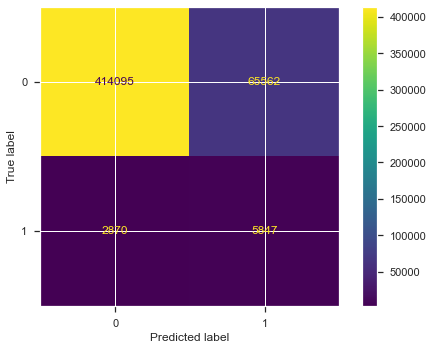

In [188]:
plot_confusion_matrix(pipe6, X_train, y_train)

train_predict_6 = pipe6.predict(X_train)

print('XGBoost TRAIN Recall Score:', recall_score(y_train, train_predict_6))
print('XGBoost TRAIN Precision Score:', precision_score(y_train, train_predict_6))

XGBoost TEST Recall Score: 0.65814266487214
XGBoost TEST Precision Score: 0.08284976068448473


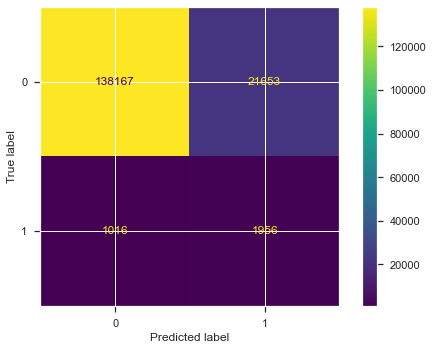

In [189]:
plot_confusion_matrix(pipe6, X_test, y_test)

test_predict_6 = pipe6.predict(X_test)

print('XGBoost TEST Recall Score:', recall_score(y_test, test_predict_6))
print('XGBoost TEST Precision Score:', precision_score(y_test, test_predict_6))

# Trying Different Target Bin

In [126]:
X2 = df_model.drop(['FATAL/INCAPACITATING_INJURY','TARGET_2'], axis = 1)
y2 = df_model['TARGET_2']

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, random_state = 14)


0         0
1         0
2         0
3         0
4         0
         ..
653696    0
653697    0
653698    0
653699    0
653700    0
Name: TARGET_2, Length: 651166, dtype: int64

In [129]:
param_grid = {'classifier__scale_pos_weight' : [1, 10, 100]}
gs3 = GridSearchCV(pipe5, param_grid = param_grid, scoring = 'recall', cv = 3)

gs3.fit(X_train2, y_train2)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median'))]),
                                                                         ['AGE']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder())]),
                                                                         ['WEATHER_CONDITION',
                                                                          'LIGHTING_CONDITION',
                                                     

In [131]:
gs3.cv_results_

{'mean_fit_time': array([15.50829927, 16.17168339, 16.35733406]),
 'std_fit_time': array([0.78085204, 0.1062253 , 0.37191578]),
 'mean_score_time': array([0.68268339, 0.66128707, 0.72381234]),
 'std_score_time': array([0.00880576, 0.0428096 , 0.00387516]),
 'param_classiffier__scale_pos_weight': masked_array(data=[1, 10, 100],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'classiffier__scale_pos_weight': 1},
  {'classiffier__scale_pos_weight': 10},
  {'classiffier__scale_pos_weight': 100}],
 'split0_test_score': array([0.30026333, 0.63258723, 0.9797235 ]),
 'split1_test_score': array([0.30396998, 0.64665218, 0.98650339]),
 'split2_test_score': array([0.31231073, 0.63462804, 0.9841343 ]),
 'mean_test_score': array([0.30551468, 0.63795582, 0.98345373]),
 'std_test_score': array([0.00503816, 0.00620544, 0.0028094 ]),
 'rank_test_score': array([3, 2, 1], dtype=int32)}

In [132]:
gs3.best_params_

{'classiffier__scale_pos_weight': 100}

XGBoost TEST Recall Score: 0.9878869448183042
XGBoost TEST Precision Score: 0.021677655623564853


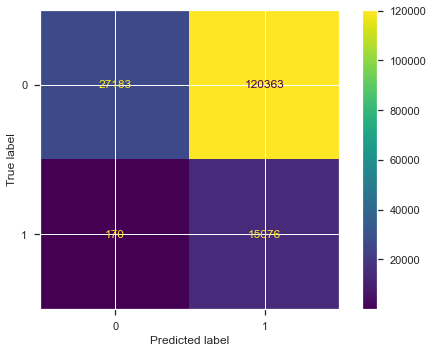

In [133]:
plot_confusion_matrix(gs3, X_test2, y_test2)

test_predict_new = gs3.predict(X_test2)

print('XGBoost TEST Recall Score:', recall_score(y_test, test_predict_new))
print('XGBoost TEST Precision Score:', precision_score(y_test, test_predict_new))

In [134]:
param_grid = {'classifier__scale_pos_weight' : [1, 10, 100]}
gs4 = GridSearchCV(pipe5, param_grid = param_grid, scoring = 'roc_auc', cv = 3)

gs4.fit(X_train2, y_train2)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median'))]),
                                                                         ['AGE']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder())]),
                                                                         ['WEATHER_CONDITION',
                                                                          'LIGHTING_CONDITION',
                                                     

In [135]:
gs4.cv_results_



{'mean_fit_time': array([15.53429333, 16.41362206, 16.71633196]),
 'std_fit_time': array([0.28295786, 0.04696702, 0.27204543]),
 'mean_score_time': array([0.67918603, 0.67127959, 0.72043896]),
 'std_score_time': array([0.01562104, 0.05592217, 0.01314279]),
 'param_classiffier__scale_pos_weight': masked_array(data=[1, 10, 100],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'classiffier__scale_pos_weight': 1},
  {'classiffier__scale_pos_weight': 10},
  {'classiffier__scale_pos_weight': 100}],
 'split0_test_score': array([0.82021589, 0.81903417, 0.81455711]),
 'split1_test_score': array([0.82802395, 0.82572425, 0.82220329]),
 'split2_test_score': array([0.82509345, 0.82282304, 0.81894702]),
 'mean_test_score': array([0.82444443, 0.82252715, 0.81856914]),
 'std_test_score': array([0.00322049, 0.00273922, 0.00313295]),
 'rank_test_score': array([1, 2, 3], dtype=int32)}

In [136]:
gs4.best_params_

{'classiffier__scale_pos_weight': 1}

XGBoost TEST Recall Score: 0.3731493943472409
XGBoost TEST Precision Score: 0.15237702665567462


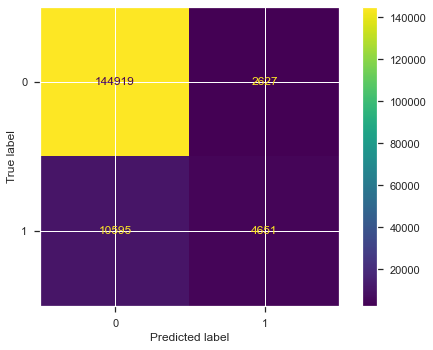

In [137]:
plot_confusion_matrix(gs4, X_test2, y_test2)

test_predict_new = gs4.predict(X_test2)

print('XGBoost TEST Recall Score:', recall_score(y_test, test_predict_new))
print('XGBoost TEST Precision Score:', precision_score(y_test, test_predict_new))

# XGBOOST parameter tuning

In [213]:
sample_weights = compute_sample_weight(class_weight='balanced', y = y_train)

pipe8 = Pipeline(steps=[('preprocessor', preprocessor),
                       ('classifier', XGBClassifier(max_depth = 4, max_leaves = 10, eta = 0.1, subsample = 0.66, scale_pos_weight = 54) )])

pipe8.fit(X_train,y_train) # , classifier__sample_weight = sample_weights)

param_grid = {'classifier__eta' : [ .1] ,
              'classifier__max_leaves' : [10, 20, 100]
             }

gs_f = GridSearchCV(pipe8, param_grid = param_grid,  cv = 3, scoring = 'f1')

gs_f.fit(X_train,y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median'))]),
                                                                         ['AGE']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder())]),
                                                                         ['WEATHER_CONDITION',
                                                                          'LIGHTING_CONDITION',
                                                     

In [214]:
gs_f.cv_results_

{'mean_fit_time': array([11.04626258, 11.43224708, 11.60553646]),
 'std_fit_time': array([0.0478688 , 0.09019235, 0.06360118]),
 'mean_score_time': array([0.58994802, 0.60238703, 0.60520768]),
 'std_score_time': array([0.01270436, 0.00254568, 0.00541198]),
 'param_classifier__eta': masked_array(data=[0.1, 0.1, 0.1],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_classifier__max_leaves': masked_array(data=[10, 20, 100],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'classifier__eta': 0.1, 'classifier__max_leaves': 10},
  {'classifier__eta': 0.1, 'classifier__max_leaves': 20},
  {'classifier__eta': 0.1, 'classifier__max_leaves': 100}],
 'split0_test_score': array([0.14507772, 0.14507772, 0.14507772]),
 'split1_test_score': array([0.14567459, 0.14567459, 0.14567459]),
 'split2_test_score': array([0.14233129, 0.14233129, 0.14233129]),
 'mean_test_score': array([0.1443612, 0.1

In [215]:
gs_f.best_params_

{'classifier__eta': 0.1, 'classifier__max_leaves': 10}

XG Boost Recall Score: 0.655114401076716
XG Boost Precision Score: 0.08403832872928177


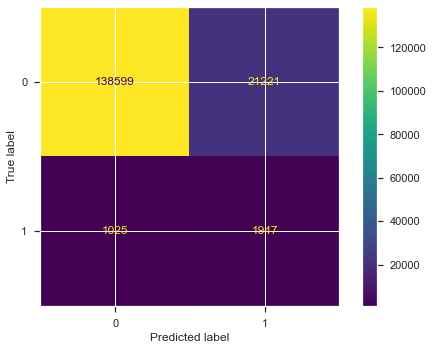

In [206]:
test_predict_8 = pipe8.predict(X_test)

plot_confusion_matrix(pipe8, X_test, y_test)

print('XG Boost Recall Score:' , recall_score(y_test, test_predict_8))
print('XG Boost Precision Score:' , precision_score(y_test, test_predict_8))

# Naive Bayes

In [203]:
pipe9 = Pipeline(steps=[('preprocessor', preprocessor),
                       ('classifier', GaussianNB() )])

pipe9.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['AGE']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  ['WEATHER_CONDITION',
                                                   'LIGHTING_CONDITION',
                                                   'FIRST_CRASH_TYPE',
                                                   'ALIGNMENT',
                                                   'ROADWAY_SURFACE_COND',
                                                   'ROAD_DEFECT',
                          

Naive Bayes Recall Score: 0.6251682368775235
Naive Bayes Precision Score: 0.08240198687244989


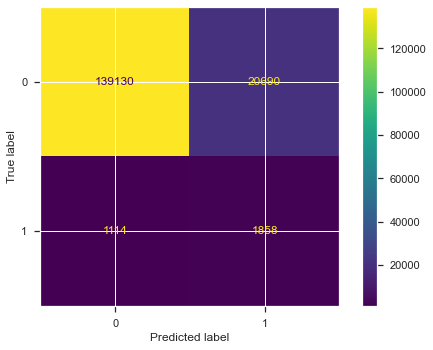

In [205]:
test_predict_9 = pipe9.predict(X_test)

plot_confusion_matrix(pipe9, X_test, y_test)

print('Naive Bayes Recall Score:' , recall_score(y_test, test_predict_9))
print('Naive Bayes Precision Score:' , precision_score(y_test, test_predict_9))

# Trying Injuries Only

In [322]:
df_model_injonly = df_model.drop(df_model[df_model['INJURIES_ONLY_TARGET'] == 2].index)

X = df_model_injonly.drop(['FATAL/INCAPACITATING_INJURY','TARGET_2','INJURIES_ONLY_TARGET'], axis = 1)
y = df_model_injonly['INJURIES_ONLY_TARGET']

X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X, y, random_state = 14)
X_train_3

,POSTED_SPEED_LIMIT,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,ALIGNMENT,ROADWAY_SURFACE_COND,ROAD_DEFECT,DAMAGE,NUM_UNITS,CRASH_HOUR,CRASH_DAY_OF_WEEK,AGE,PERSON_COUNT,AIRBAG_DEPLOYED,SAFETY_EQUIPMENT
99846,30,CLEAR,"DARKNESS, LIGHTED ROAD",PEDESTRIAN/CYCLIST,STRAIGHT AND LEVEL,DRY,NO DEFECTS,UNDER $1500,2,20,4,24.5,2,No,Unknown
144005,30,CLEAR,DAYLIGHT,PEDESTRIAN/CYCLIST,STRAIGHT AND LEVEL,DRY,NO DEFECTS,"OVER $1,500",2,12,6,52.0,2,No,No
268842,30,CLEAR,DAYLIGHT,ANGEL/SIDE,STRAIGHT AND LEVEL,DRY,NO DEFECTS,"OVER $1,500",2,7,4,34.5,2,No,Unknown
236176,15,CLEAR,DARKNESS,PARKED/OBJECT/SLOW,STRAIGHT AND LEVEL,DRY,UNKNOWN,"OVER $1,500",1,20,7,47.5,2,Yes,Unknown
105127,30,CLEAR,"DARKNESS, LIGHTED ROAD",ANGEL/SIDE,STRAIGHT AND LEVEL,DRY,NO DEFECTS,"OVER $1,500",2,21,1,32.5,4,Yes,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244400,30,CLEAR,"DARKNESS, LIGHTED ROAD",ANGEL/SIDE,STRAIGHT AND LEVEL,DRY,NO DEFECTS,"OVER $1,500",3,23,7,33.5,2,Yes,Unknown
556448,30,CLEAR,DAYLIGHT,SAME DIRECTION,STRAIGHT AND LEVEL,DRY,NO DEFECTS,"OVER $1,500",2,14,6,41.0,2,No,Unknown
98110,35,RAIN/SNOW,DAYLIGHT,SAME DIRECTION,STRAIGHT AND LEVEL,WET,NO DEFECTS,UNDER $1500,2,18,4,29.5,2,No,Unknown
144150,25,CLEAR,DAYLIGHT,SAME DIRECTION,STRAIGHT AND LEVEL,DRY,NO DEFECTS,UNDER $1500,2,14,3,47.0,2,No,Unknown


In [369]:
sample_weights = compute_sample_weight(class_weight='balanced', y = y_train_3)

num = ['AGE']
cat = ['WEATHER_CONDITION','LIGHTING_CONDITION','FIRST_CRASH_TYPE','ALIGNMENT','ROADWAY_SURFACE_COND','ROAD_DEFECT','AIRBAG_DEPLOYED','SAFETY_EQUIPMENT','DAMAGE']

num_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy = 'median'))])

cat_transformer = Pipeline(steps=[('onehot', OneHotEncoder())])

preprocessor = ColumnTransformer(transformers=[('num', num_transformer, num),
                                               ('cat', cat_transformer, cat)])

pipe_injonly = Pipeline(steps=[('preprocessor', preprocessor),
                       ('classifier', XGBClassifier(max_depth = 3, max_leaves = 1, eta = 0.1, scale_pos_weight = 7, subsample = 1))])



pipe_injonly.fit(X_train_3,y_train_3) # , classifier__sample_weight = sample_weights)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['AGE']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  ['WEATHER_CONDITION',
                                                   'LIGHTING_CONDITION',
                                                   'FIRST_CRASH_TYPE',
                                                   'ALIGNMENT',
                                                   'ROADWAY_SURFACE_COND',
                                                   'ROAD_DEFECT',
                          

XGBoost Test Recall: 0.9746582194064688
XGBoost Test Precision: 0.20008214114586897


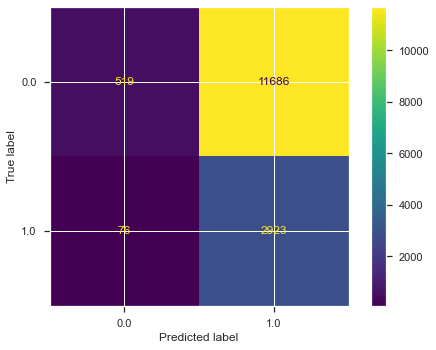

In [370]:
plot_confusion_matrix(pipe_injonly, X_test_3, y_test_3)

print('XGBoost Test Recall:', recall_score(y_test_3, pipe_injonly.predict(X_test_3)))
print('XGBoost Test Precision:', precision_score(y_test_3, pipe_injonly.predict(X_test_3)))

In [378]:

pipe_injonly2 = Pipeline(steps=[('preprocessor', preprocessor),
                       ('classifier', LogisticRegression(class_weight = 'balanced', max_iter = 200))])



pipe_injonly2.fit(X_train_3,y_train_3)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['AGE']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  ['WEATHER_CONDITION',
                                                   'LIGHTING_CONDITION',
                                                   'FIRST_CRASH_TYPE',
                                                   'ALIGNMENT',
                                                   'ROADWAY_SURFACE_COND',
                                                   'ROAD_DEFECT',
                          

LogReg Test Recall: 0.5231743914638213
LogReg Test Precision: 0.23830498177399756


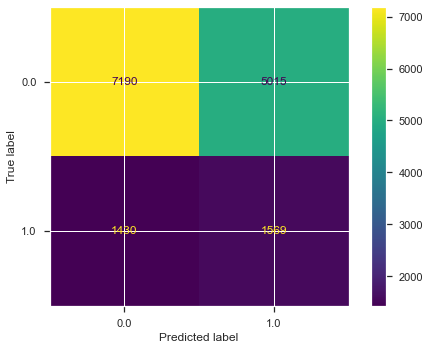

In [379]:
plot_confusion_matrix(pipe_injonly2, X_test_3, y_test_3)

print('LogReg Test Recall:', recall_score(y_test_3, pipe_injonly2.predict(X_test_3)))
print('LogReg Test Precision:', precision_score(y_test_3, pipe_injonly2.predict(X_test_3)))

# Trying Damage Target

In [386]:
X = df_model.drop(['DAMAGE','TARGET_2','INJURIES_ONLY_TARGET'], axis = 1)
y = df_model['DAMAGE']

y = y.apply(lambda x: 0 if x == 'UNDER $1500' else 1)


X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(X, y, random_state = 14)
y

0         1
1         1
2         1
3         0
4         1
         ..
653696    1
653697    1
653698    1
653699    1
653700    1
Name: DAMAGE, Length: 651166, dtype: int64

In [437]:
sample_weights = compute_sample_weight(class_weight='balanced', y = y_train_4)

num = ['AGE']
cat = ['WEATHER_CONDITION','LIGHTING_CONDITION','FIRST_CRASH_TYPE','ALIGNMENT','ROADWAY_SURFACE_COND','ROAD_DEFECT','AIRBAG_DEPLOYED','SAFETY_EQUIPMENT','FATAL/INCAPACITATING_INJURY']

num_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy = 'median'))])

cat_transformer = Pipeline(steps=[('onehot', OneHotEncoder())])

preprocessor = ColumnTransformer(transformers=[('num', num_transformer, num),
                                               ('cat', cat_transformer, cat)])

pipe_damage = Pipeline(steps=[('preprocessor', preprocessor),
                       ('classifier', XGBClassifier(max_depth = 5, eta = 0.1, subsample = 0.66, scale_pos_weight = 1.5, tree_method = 'hist', n_estimators = 1000, colsample_bytree = 0.66, colsample_bynode = 0.66,colsample_bylevel = .66))])



pipe_damage.fit(X_train_4,y_train_4) #, classifier__sample_weight = sample_weights)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['AGE']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  ['WEATHER_CONDITION',
                                                   'LIGHTING_CONDITION',
                                                   'FIRST_CRASH_TYPE',
                                                   'ALIGNMENT',
                                                   'ROADWAY_SURFACE_COND',
                                                   'ROAD_DEFECT',
                          

XGBoost Test Recall: 0.981855762475436
XGBoost Test Precision: 0.616152838567458
XGBoost Test Accuracy: 0.6200304683276819
XGBoost Test F1 Score: 0.7571588972903368


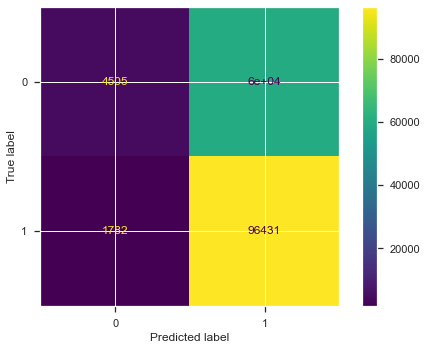

In [438]:
plot_confusion_matrix(pipe_damage, X_test_4, y_test_4)


print('XGBoost Test Recall:', recall_score(y_test_4, pipe_damage.predict(X_test_4)))
print('XGBoost Test Precision:', precision_score(y_test_4, pipe_damage.predict(X_test_4)))
print('XGBoost Test Accuracy:', accuracy_score(y_test_4, pipe_damage.predict(X_test_4)))
print('XGBoost Test F1 Score:', f1_score(y_test_4, pipe_damage.predict(X_test_4)))

In [414]:
param_grid = {'classifier__eta' : [ .1, .2, .3] ,
              'classifier__max_depth' : [3, 4, 5]
             }

gs_damage = GridSearchCV(pipe_damage, param_grid = param_grid,  cv = 3, scoring = 'precision')

gs_damage.fit(X_train_4,y_train_4)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median'))]),
                                                                         ['AGE']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder())]),
                                                                         ['WEATHER_CONDITION',
                                                                          'LIGHTING_CONDITION',
                                                     

In [415]:
gs_damage.cv_results_

{'mean_fit_time': array([ 8.33669337, 10.80605292, 13.47949696,  8.96328735, 11.14316408,
        13.66143401,  9.014057  , 11.41664394, 13.96523563]),
 'std_fit_time': array([0.27410654, 0.21752715, 0.11321532, 0.1568294 , 0.03624053,
        0.09263773, 0.11184284, 0.1925939 , 0.22442256]),
 'mean_score_time': array([0.60921224, 0.64253251, 0.68388669, 0.65372531, 0.64784034,
        0.67741664, 0.63922731, 0.65680989, 0.71102802]),
 'std_score_time': array([0.01029083, 0.00520887, 0.00475122, 0.0076683 , 0.00920782,
        0.01528193, 0.00614348, 0.00237827, 0.00817194]),
 'param_classifier__eta': masked_array(data=[0.1, 0.1, 0.1, 0.2, 0.2, 0.2, 0.3, 0.3, 0.3],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'param_classifier__max_depth': masked_array(data=[3, 4, 5, 3, 4, 5, 3, 4, 5],
              mask=[False, False, False, False, False, False, False, False,
               

In [416]:
gs_damage.best_params_

{'classifier__eta': 0.1, 'classifier__max_depth': 5}

In [456]:
pipe_damage_2 = Pipeline(steps=[('preprocessor', preprocessor),
                       ('classifier', AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = 5), n_estimators = 100))])



pipe_damage_2.fit(X_train_4,y_train_4 , classifier__sample_weight = sample_weights)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['AGE']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  ['WEATHER_CONDITION',
                                                   'LIGHTING_CONDITION',
                                                   'FIRST_CRASH_TYPE',
                                                   'ALIGNMENT',
                                                   'ROADWAY_SURFACE_COND',
                                                   'ROAD_DEFECT',
                          

XGBoost Test Recall: 0.5270585360390172
XGBoost Test Precision: 0.6285318795002246
XGBoost Test Accuracy: 0.5267457860337117
XGBoost Test F1 Score: 0.5733399789555297


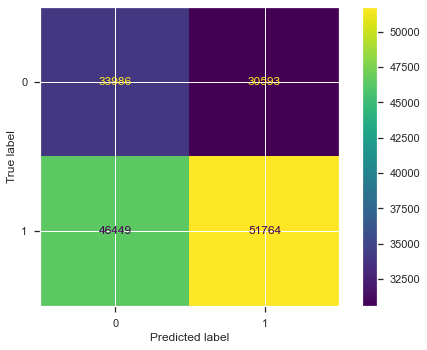

In [457]:
plot_confusion_matrix(pipe_damage_2, X_test_4, y_test_4)


print('XGBoost Test Recall:', recall_score(y_test_4, pipe_damage_2.predict(X_test_4)))
print('XGBoost Test Precision:', precision_score(y_test_4, pipe_damage_2.predict(X_test_4)))
print('XGBoost Test Accuracy:', accuracy_score(y_test_4, pipe_damage_2.predict(X_test_4)))
print('XGBoost Test F1 Score:', f1_score(y_test_4, pipe_damage_2.predict(X_test_4)))